In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
from collections import Counter
import numpy as np

Using TensorFlow backend.


In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Setup

In [5]:
audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Loading

In [10]:
%%file load_blockwise.py

audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

import time
import librosa
import numpy as np
import soundfile as sf

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    h_target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True,
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_target.append(sample.h_category)
            target.append(sample.target)
        if debug:
            print("Done")
    if debug:
        print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_target), np.array(target)

def load_file_blockwise(filename, blocksize=1024, overlap=512, debug=False):
    items = []
    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + filename, 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True,
                         fill_value=0.0)
    sr = sf.info(audio_dir + filename).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = librosa.resample(y, sr, SR)
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        
    if debug:
        print("Done")

    return np.array(items)

Overwriting load_blockwise.py


In [11]:
%%time
from load_blockwise import load_audio_blockwise

%memit train_X, train_y, train_yy = load_audio_blockwise(dataset[dataset.fold != 1], orig_blocksize, orig_overlap)

peak memory: 2452.10 MiB, increment: 2148.07 MiB
CPU times: user 4min 5s, sys: 1.43 s, total: 4min 6s
Wall time: 4min 7s


In [12]:
%%time
%memit test_X, test_y, test_yy = load_audio_blockwise(dataset[dataset.fold == 1], orig_blocksize, orig_overlap)

peak memory: 1786.82 MiB, increment: 488.58 MiB
CPU times: user 1min 2s, sys: 436 ms, total: 1min 2s
Wall time: 1min 2s


In [13]:
train_y = np.vstack([train_y, train_yy]).T
test_y = np.vstack([test_y, test_yy]).T

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [14]:
%%file cnnmult.py

import numpy as np
import inspect
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, InputLayer
from kapre.time_frequency import Melspectrogram, Spectrogram

from keras.wrappers.scikit_learn import KerasClassifier

SR=16000

class CNN_Multilayer(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=50, batch_size=128, validation_split=0.05,
                       a_epochs=50, a_batch_size=128,
                       i_epochs=50, i_batch_size=128,
                       verbose=1):
        
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)
            pass
    
    
    def fit(self, X, y):
        
        X = np.array(X)
        y = np.array(y)
        
        print(X.shape)
        
        dims = X.shape[1]
        t_y = y[:,0]
        a_y = y[:,1][t_y == 0]
        i_y = y[:,1][t_y == 1]
        
        """Top layer of hierarchy"""
        self.clf = KerasClassifier(build_fn=self.deep_net,
                                   feature_count=SR * 5,
                                   epochs=self.epochs, 
                                   batch_size=self.batch_size, 
                                   validation_split=self.validation_split,
                                   verbose=self.verbose
                                  )
        self.clf.fit(X, t_y)
        
        """Animal Layer"""
        self.a_clf = KerasClassifier(build_fn=self.deep_net_a,
                                       feature_count=SR * 5,
                                       epochs=self.a_epochs, 
                                       batch_size=self.a_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        
        self.a_clf.fit(X[t_y == 0], a_y)
        
        """Interacting Materials Layer"""
        self.i_clf = KerasClassifier(build_fn=self.deep_net_i, 
                                       feature_count=SR * 5,
                                       epochs=self.i_epochs, 
                                       batch_size=self.i_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        self.i_clf.fit(X[t_y == 1], i_y)
        
        return self
        
    def predict(self, X, y=None):
        predictions=[]
        
        for x in X:
            prob = self.clf.predict_proba(x, verbose=0).squeeze()
            print(prob)
            if prob[0] > 0.75:
                pred = self.a_clf.predict(x, verbose=0).squeeze()
            elif prob[1] > 0.75:
                pred = self.i_clf.predict(x, verbose=0).squeeze()
            else:
                a_pred = self.a_clf.predict(x, verbose=0).squeeze()
                i_pred = self.i_clf.predict(x, verbose=0).squeeze()
                
                a_prob = self.a_clf.predict_proba(x, verbose=0).squeeze() * prob[0]
                i_prob = self.i_clf.predict_proba(x, verbose=0).squeeze() * prob[1]
                
                if(np.max(a_prob) > np.max(i_prob)):
                    pred = a_pred
                else:
                    pred = i_pred
                    
            predictions.append(pred)
        
        return predictions
    
    def predict_proba(self, X, y=None):
        
        prob = self.clf.predict_proba(X, verbose=0).squeeze()
#         print(prob)

        prob_a = np.multiply(self.a_clf.predict_proba(X, verbose=0).squeeze(),prob[0])
#         print(prob_a)

        prob_i = np.multiply(self.i_clf.predict_proba(X, verbose=0).squeeze(),prob[1])
#         print(prob_i)
        print()
        
        probs = [None] * 50
        for counter, j in enumerate(self.a_clf.classes_):
            probs[j] = prob_a[counter]
        for counter, j in enumerate(self.i_clf.classes_):
            probs[j] = prob_i[counter]
            
        return np.array(probs)
        
    
    def deep_net(self, feature_count):
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

        # Compile model
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        model.summary()


        return model

    def deep_net_a(self, feature_count):
        # Create Model
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(18, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    def deep_net_i(self, feature_count):
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

Overwriting cnnmult.py


In [15]:
from cnnmult import CNN_Multilayer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA

clf = CNN_Multilayer()

clf.fit(train_X, train_y)

(1600, 1, 80000)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_1 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                69664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0   

972/972 [==============================] - 27s 28ms/step - loss: 3.1922 - acc: 0.0916 - val_loss: 3.2345 - val_acc: 0.0577
Epoch 8/50
972/972 [==============================] - 28s 29ms/step - loss: 3.1568 - acc: 0.1204 - val_loss: 3.2072 - val_acc: 0.1346
Epoch 9/50
972/972 [==============================] - 28s 29ms/step - loss: 3.1152 - acc: 0.1317 - val_loss: 3.1655 - val_acc: 0.0962
Epoch 10/50
972/972 [==============================] - 27s 28ms/step - loss: 3.0727 - acc: 0.1471 - val_loss: 3.1387 - val_acc: 0.0962
Epoch 11/50
972/972 [==============================] - 28s 28ms/step - loss: 3.0374 - acc: 0.1379 - val_loss: 3.1278 - val_acc: 0.0962
Epoch 12/50
972/972 [==============================] - 27s 28ms/step - loss: 2.9970 - acc: 0.1687 - val_loss: 3.0786 - val_acc: 0.1154
Epoch 13/50
972/972 [==============================] - 27s 28ms/step - loss: 2.9425 - acc: 0.1708 - val_loss: 3.0294 - val_acc: 0.1346
Epoch 14/50
972/972 [==============================] - 28s 28ms/step 

CNN_Multilayer(a_batch_size=128, a_epochs=50, batch_size=128, epochs=50,
        i_batch_size=128, i_epochs=50, validation_split=0.05, verbose=1)

In [16]:
print(test_X[:, np.newaxis, :, :].shape)

(400, 1, 1, 80000)


[3.4570694e-05 9.9996543e-01]
[0.37366027 0.62633973]
[0. 1.]
[0. 1.]
[0.3581782 0.6418218]
[0.3053583 0.6946417]
[0. 1.]
[3.0851364e-04 9.9969149e-01]
[9.999243e-01 7.569283e-05]
[9.5367432e-07 9.9999905e-01]
[0.00259 0.99741]
[0. 1.]
[0. 1.]
[0. 1.]
[9.9992347e-01 7.6509605e-05]
[0. 1.]
[0.026218 0.973782]
[0.02966648 0.9703335 ]
[9.974837e-04 9.990025e-01]
[7.7545643e-04 9.9922454e-01]
[0.00457239 0.9954276 ]
[7.1525574e-07 9.9999928e-01]
[0. 1.]
[3.3378601e-06 9.9999666e-01]
[6.198883e-06 9.999938e-01]
[7.1525574e-07 9.9999928e-01]
[0.0034281 0.9965719]
[0.05315822 0.9468418 ]
[0.01625061 0.9837494 ]
[0.9159558  0.08404423]
[2.9563904e-05 9.9997044e-01]
[0.56831634 0.43168366]
[0.02697241 0.9730276 ]
[0. 1.]
[0.99678886 0.00321115]
[0. 1.]
[1.1920929e-07 9.9999988e-01]
[0.32433033 0.67566967]
[0.00936139 0.9906386 ]
[1.1920929e-07 9.9999988e-01]
[2.9921532e-05 9.9997008e-01]
[0. 1.]
[0. 1.]
[1.1920929e-07 9.9999988e-01]
[2.3841858e-07 9.9999976e-01]
[9.9995202e-01 4.7980644e-05]
[9

[0. 1.]
[0. 1.]
[1.0000000e+00 1.8814312e-18]
[1.0000000e+00 1.1078952e-09]
[1.692772e-05 9.999831e-01]
[0. 1.]
[0.8906886  0.10931142]
[0.0051015 0.9948985]
[0. 1.]
[0. 1.]
[0. 1.]
[0.5387038 0.4612962]
[0.29497576 0.70502424]
[0.9935201  0.00647989]
[0.01646399 0.983536  ]
[0.86332023 0.13667977]
[0.9167429  0.08325705]
[0. 1.]
[0. 1.]
[0.9533512  0.04664881]
[1.0371208e-05 9.9998963e-01]
[0.77265596 0.22734407]
[8.0943108e-05 9.9991906e-01]
[0.00315511 0.9968449 ]
[0.03242671 0.9675733 ]
[0. 1.]
[3.9583445e-04 9.9960417e-01]
[0.14740741 0.8525926 ]
[2.5629997e-05 9.9997437e-01]
[0.9789939 0.0210061]
[0.9983206  0.00167941]
[0.00105745 0.99894255]
[9.787083e-05 9.999021e-01]
[0.99602354 0.00397646]
[1.847744e-05 9.999815e-01]
[0.748041   0.25195903]
[0.02825558 0.9717444 ]
[0.00854176 0.99145824]
[7.1525574e-07 9.9999928e-01]
[4.8637390e-05 9.9995136e-01]
[0. 1.]
[0.00784969 0.9921503 ]
[0.00105542 0.9989446 ]
[2.3841858e-06 9.9999762e-01]
[0.94284016 0.05715986]
[9.999089e-01 9.1051

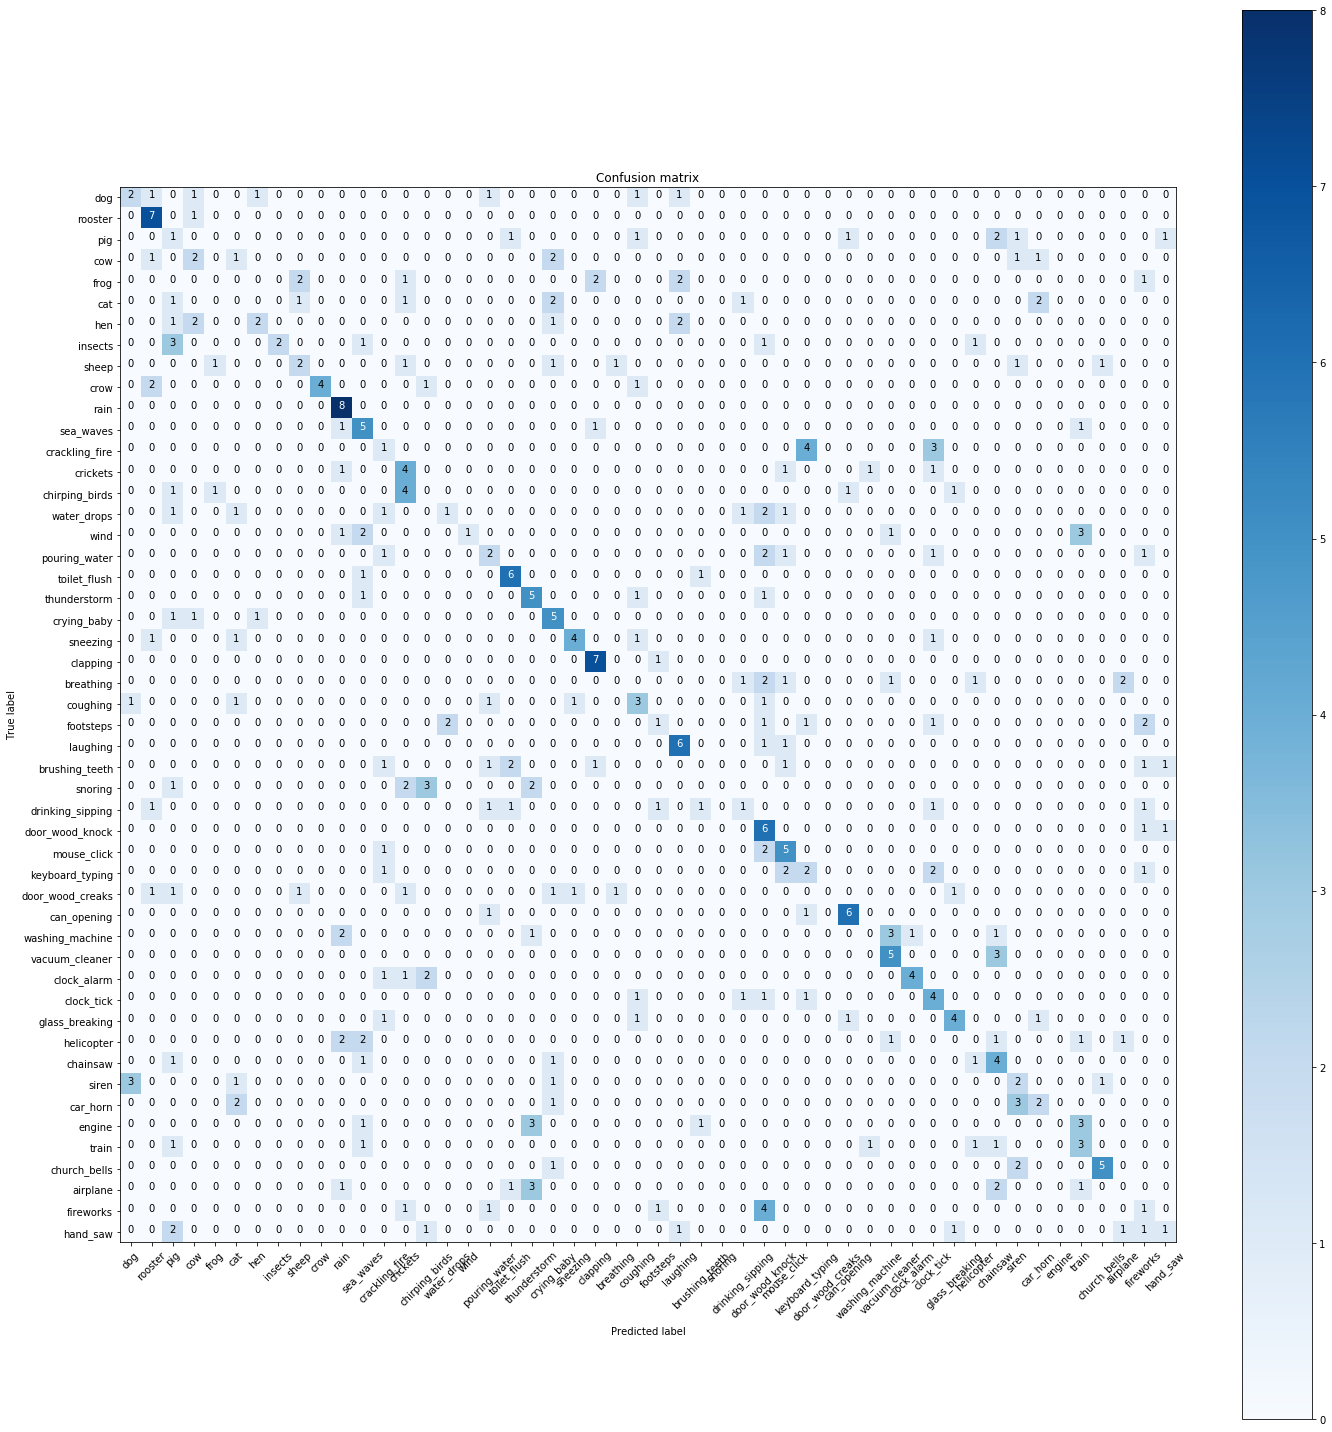

In [17]:
pred = clf.predict(test_X[:, np.newaxis, :, :])
print(metrics.accuracy_score(test_y[:,1], pred))
cm = metrics.confusion_matrix(test_y[:,1], pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [26]:
%%time
import time
from load_blockwise import load_file_blockwise

predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

test = dataset[dataset.fold == 1].reset_index()
    
for data_iloc in range(0,len(test)):
    s_time = time.time()
    x_file = load_file_blockwise(test.iloc[data_iloc].filename,
                                 blocksize=orig_blocksize,
                                 overlap=orig_overlap)
    y_file = test.iloc[data_iloc].target
    
    pred = clf.predict(x_file)
    b = Counter(np.array(pred))
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(y_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))



[3.4570694e-05 9.9996543e-01]
	File Time: 0.29184865951538086
[0.37366027 0.62633973]
	File Time: 0.27004289627075195
[0. 1.]
	File Time: 0.2558479309082031
[0. 1.]
	File Time: 0.26534390449523926
[0.3581782 0.6418218]
	File Time: 0.25615477561950684
[0.3053583 0.6946417]
	File Time: 0.2848482131958008
[0. 1.]
	File Time: 0.2642688751220703
[3.0851364e-04 9.9969149e-01]
	File Time: 0.2256450653076172
[9.999243e-01 7.569283e-05]
	File Time: 0.2663130760192871
[9.5367432e-07 9.9999905e-01]
	File Time: 0.26271867752075195
[0.00259 0.99741]
	File Time: 0.2689094543457031
[0. 1.]
	File Time: 0.22986936569213867
[0. 1.]
	File Time: 0.2300570011138916
[0. 1.]
	File Time: 0.21752595901489258
[9.9992347e-01 7.6509605e-05]
	File Time: 0.18605494499206543
[0. 1.]
	File Time: 0.25739097595214844
[0.026218 0.973782]
	File Time: 0.23472809791564941
[0.02966648 0.9703335 ]
	File Time: 0.1923975944519043
[9.974837e-04 9.990025e-01]
	File Time: 0.2592759132385254
[7.7545643e-04 9.9922454e-01]
	File Tim

[2.3931265e-04 9.9976069e-01]
	File Time: 0.2781343460083008
[4.7683716e-07 9.9999952e-01]
	File Time: 0.233062744140625
[1.5234947e-04 9.9984765e-01]
	File Time: 0.2446269989013672
[3.552437e-05 9.999645e-01]
	File Time: 0.21390771865844727
[0.92247504 0.07752497]
	File Time: 0.26461172103881836
[0.85541654 0.14458345]
	File Time: 0.2853538990020752
[0.954474   0.04552605]
	File Time: 0.24043011665344238
[1.1205673e-05 9.9998879e-01]
	File Time: 0.26503825187683105
[0.9970796  0.00292041]
	File Time: 0.2817962169647217
[9.9984640e-01 1.5361424e-04]
	File Time: 0.2319352626800537
[0.37398177 0.6260182 ]
	File Time: 0.2568485736846924
[0.0010547 0.9989453]
	File Time: 0.25736451148986816
[5.5915117e-04 9.9944085e-01]
	File Time: 0.22455739974975586
[0.96038437 0.03961561]
	File Time: 0.22688889503479004
[9.9990815e-01 9.1875540e-05]
	File Time: 0.21070194244384766
[1.0000000e+00 2.8075657e-08]
	File Time: 0.17645716667175293
[9.990460e-01 9.539525e-04]
	File Time: 0.26347851753234863
[9

[0.99258643 0.00741354]
	File Time: 0.19180727005004883
[1.0000000e+00 1.3027586e-12]
	File Time: 0.17918968200683594
[0.01286453 0.98713547]
	File Time: 0.19585251808166504
[4.066825e-04 9.995933e-01]
	File Time: 0.18730735778808594
[9.995223e-01 4.776692e-04]
	File Time: 0.1981213092803955
[9.9986428e-01 1.3574905e-04]
	File Time: 0.17870569229125977
[0. 1.]
	File Time: 0.19613432884216309
[2.3841858e-07 9.9999976e-01]
	File Time: 0.1856539249420166
[2.169609e-05 9.999783e-01]
	File Time: 0.20328164100646973
[0.00147825 0.99852175]
	File Time: 0.26781678199768066
[5.297065e-04 9.994703e-01]
	File Time: 0.27550578117370605
[1.6903877e-04 9.9983096e-01]
	File Time: 0.2681159973144531
[0.00878549 0.9912145 ]
	File Time: 0.23861026763916016
[0. 1.]
	File Time: 0.246351957321167
[0.00166202 0.998338  ]
	File Time: 0.26827478408813477
[0.03949487 0.9605051 ]
	File Time: 0.2545130252838135
[9.999867e-01 1.331224e-05]
	File Time: 0.18910932540893555
[2.2530556e-05 9.9997747e-01]
	File Time: 

0.34
Confusion matrix, without normalization
[[2 1 0 ... 0 0 0]
 [0 7 0 ... 0 0 0]
 [0 0 1 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 2 ... 1 1 1]]


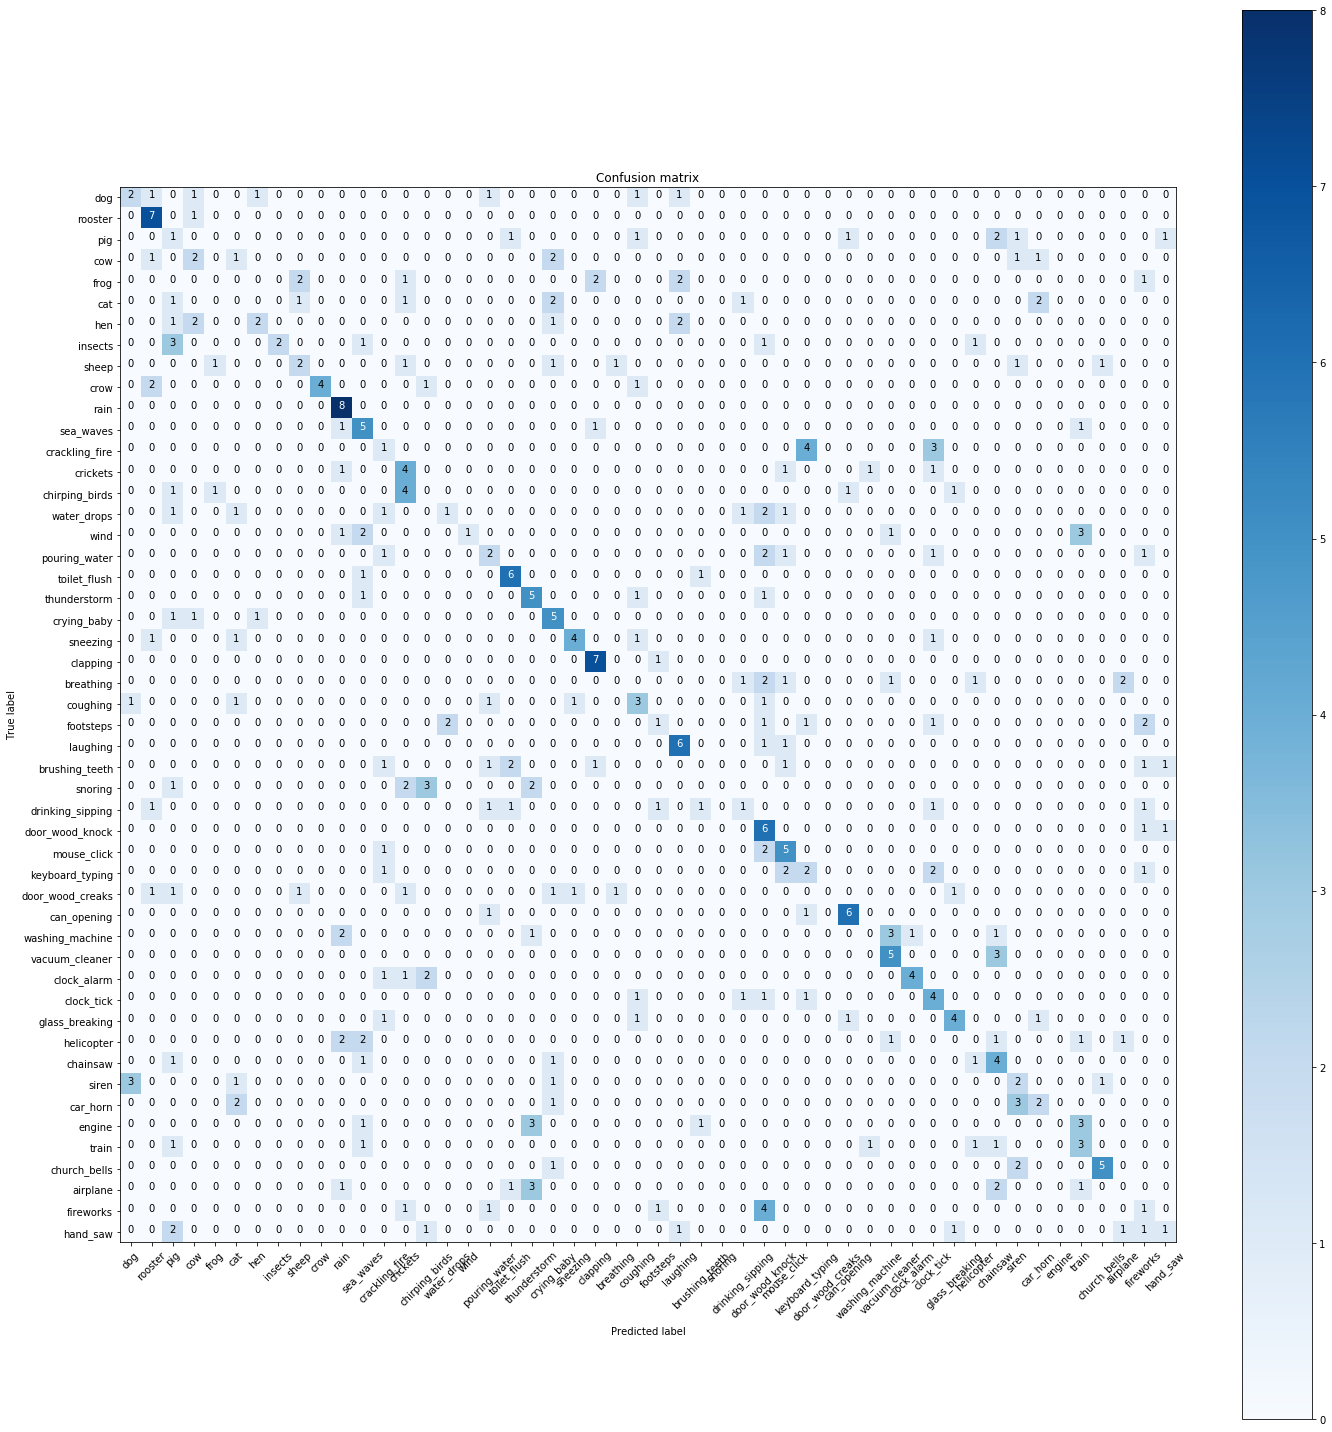

In [27]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [35]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)
    
    predictions = []

    for data_iloc in range(0,len(test)):
        x_file = load_file_blockwise(test.iloc[data_iloc].filename,
                             blocksize=orig_blocksize,
                             overlap=orig_overlap)[0]

        print(clf.predict_proba(x_file).shape)
        
        prob = clf.predict_proba(x_file)[l_l]
        pred = clf.predict(x_file[np.newaxis, :, :, :])
        
        predictions.append({
            'file': test.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': prob,
            'prediction': pred
        })
        
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    return predictions

In [36]:
%%time
preds = query_dataset('dog')


(50,)

[3.4570694e-05 9.9996543e-01]

(50,)

[0.37366027 0.62633973]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.3581782 0.6418218]

(50,)

[0.3053583 0.6946417]

(50,)

[0. 1.]

(50,)

[3.0851364e-04 9.9969149e-01]

(50,)

[9.999243e-01 7.569283e-05]

(50,)

[9.5367432e-07 9.9999905e-01]

(50,)

[0.00259 0.99741]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[9.9992347e-01 7.6509605e-05]

(50,)

[0. 1.]

(50,)

[0.026218 0.973782]

(50,)

[0.02966648 0.9703335 ]

(50,)

[9.974837e-04 9.990025e-01]

(50,)

[7.7545643e-04 9.9922454e-01]

(50,)

[0.00457239 0.9954276 ]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0. 1.]

(50,)

[3.3378601e-06 9.9999666e-01]

(50,)

[6.198883e-06 9.999938e-01]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0.0034281 0.9965719]

(50,)

[0.05315822 0.9468418 ]

(50,)

[0.01625061 0.9837494 ]

(50,)

[0.9159558  0.08404423]

(50,)

[2.9563904e-05 9.9997044e-01]

(50,)

[0.56831634 0.43168366]

(50,)

[0.02697241 0.9730276 ]

(50,)

[0. 1.]

(50,)


(50,)

[0.05046654 0.94953346]

(50,)

[0.98852605 0.01147395]

(50,)

[0.97752005 0.02247995]

(50,)

[0.9548341  0.04516589]

(50,)

[0.90805274 0.09194725]

(50,)

[1.0514259e-04 9.9989486e-01]

(50,)

[0.00162208 0.9983779 ]

(50,)

[0.74395305 0.25604695]

(50,)

[0.6588226 0.3411774]

(50,)

[0.03073663 0.9692634 ]

(50,)

[1.7303228e-04 9.9982697e-01]

(50,)

[0.9451586 0.0548414]

(50,)

[0.05632585 0.94367415]

(50,)

[6.595254e-04 9.993405e-01]

(50,)

[1.0216236e-04 9.9989784e-01]

(50,)

[0.01499164 0.98500836]

(50,)

[9.9998575e-01 1.4219460e-05]

(50,)

[0.00152498 0.998475  ]

(50,)

[0. 1.]

(50,)

[0.9746833  0.02531674]

(50,)

[0.94400114 0.05599887]

(50,)

[0. 1.]

(50,)

[0.9890737  0.01092628]

(50,)

[9.9943143e-01 5.6856778e-04]

(50,)

[0.02178746 0.97821254]

(50,)

[0.00464052 0.9953595 ]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0.912736 0.087264]

(50,)

[9.9950665e-01 4.9334794e-04]

(50,)

[4.7683716e-07 9.9999952e-01]

(50,)

[3.1352043e-05 9.999

In [37]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
#     print(misclass)
    return (count - len(misclass))/count

In [38]:
# Checking index
check_accuracy(preds, 'dog', 10)

0.2

In [40]:
accuracies = []
for cls in classes:
    preds = query_dataset(cls)
    acc = check_accuracy(preds, cls, 10)
    print(acc)
    accuracies.append(acc)
    
np.average(accuracies)


(50,)

[3.4570694e-05 9.9996543e-01]

(50,)

[0.37366027 0.62633973]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.3581782 0.6418218]

(50,)

[0.3053583 0.6946417]

(50,)

[0. 1.]

(50,)

[3.0851364e-04 9.9969149e-01]

(50,)

[9.999243e-01 7.569283e-05]

(50,)

[9.5367432e-07 9.9999905e-01]

(50,)

[0.00259 0.99741]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[9.9992347e-01 7.6509605e-05]

(50,)

[0. 1.]

(50,)

[0.026218 0.973782]

(50,)

[0.02966648 0.9703335 ]

(50,)

[9.974837e-04 9.990025e-01]

(50,)

[7.7545643e-04 9.9922454e-01]

(50,)

[0.00457239 0.9954276 ]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0. 1.]

(50,)

[3.3378601e-06 9.9999666e-01]

(50,)

[6.198883e-06 9.999938e-01]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0.0034281 0.9965719]

(50,)

[0.05315822 0.9468418 ]

(50,)

[0.01625061 0.9837494 ]

(50,)

[0.9159558  0.08404423]

(50,)

[2.9563904e-05 9.9997044e-01]

(50,)

[0.56831634 0.43168366]

(50,)

[0.02697241 0.9730276 ]

(50,)

[0. 1.]

(50,)


(50,)

[0.05046654 0.94953346]

(50,)

[0.98852605 0.01147395]

(50,)

[0.97752005 0.02247995]

(50,)

[0.9548341  0.04516589]

(50,)

[0.90805274 0.09194725]

(50,)

[1.0514259e-04 9.9989486e-01]

(50,)

[0.00162208 0.9983779 ]

(50,)

[0.74395305 0.25604695]

(50,)

[0.6588226 0.3411774]

(50,)

[0.03073663 0.9692634 ]

(50,)

[1.7303228e-04 9.9982697e-01]

(50,)

[0.9451586 0.0548414]

(50,)

[0.05632585 0.94367415]

(50,)

[6.595254e-04 9.993405e-01]

(50,)

[1.0216236e-04 9.9989784e-01]

(50,)

[0.01499164 0.98500836]

(50,)

[9.9998575e-01 1.4219460e-05]

(50,)

[0.00152498 0.998475  ]

(50,)

[0. 1.]

(50,)

[0.9746833  0.02531674]

(50,)

[0.94400114 0.05599887]

(50,)

[0. 1.]

(50,)

[0.9890737  0.01092628]

(50,)

[9.9943143e-01 5.6856778e-04]

(50,)

[0.02178746 0.97821254]

(50,)

[0.00464052 0.9953595 ]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0.912736 0.087264]

(50,)

[9.9950665e-01 4.9334794e-04]

(50,)

[4.7683716e-07 9.9999952e-01]

(50,)

[3.1352043e-05 9.999


(50,)

[1.0000000e+00 2.5024873e-09]

(50,)

[0.97626084 0.02373917]

(50,)

[0. 1.]

(50,)

[1.3232231e-05 9.9998677e-01]

(50,)

[0.9849957  0.01500431]

(50,)

[0.4339779 0.5660221]

(50,)

[0.91376466 0.08623534]

(50,)

[0.00888443 0.99111557]

(50,)

[0.12633663 0.87366337]

(50,)

[7.987022e-06 9.999920e-01]

(50,)

[0. 1.]

(50,)

[0.21291345 0.78708655]

(50,)

[0. 1.]

(50,)

[0.03579295 0.96420705]

(50,)

[0.0516274 0.9483726]

(50,)

[4.839897e-05 9.999516e-01]

(50,)

[0. 1.]

(50,)

[9.9956185e-01 4.3817336e-04]

(50,)

[9.962916e-04 9.990037e-01]

(50,)

[0.847486   0.15251395]

(50,)

[0. 1.]

(50,)

[2.515912e-04 9.997484e-01]

(50,)

[9.9995595e-01 4.4049677e-05]

(50,)

[9.9939787e-01 6.0209783e-04]

(50,)

[0. 1.]

(50,)

[0.00881076 0.99118924]

(50,)

[1.0120869e-04 9.9989879e-01]

(50,)

[5.4126978e-04 9.9945873e-01]

(50,)

[1.0000000e+00 1.2200986e-13]

(50,)

[8.5830688e-05 9.9991417e-01]

(50,)

[0. 1.]

(50,)

[0.93005043 0.06994955]

(50,)

[0.13004309 0.


(50,)

[0.03242671 0.9675733 ]

(50,)

[0. 1.]

(50,)

[3.9583445e-04 9.9960417e-01]

(50,)

[0.14740741 0.8525926 ]

(50,)

[2.5629997e-05 9.9997437e-01]

(50,)

[0.9789939 0.0210061]

(50,)

[0.9983206  0.00167941]

(50,)

[0.00105745 0.99894255]

(50,)

[9.787083e-05 9.999021e-01]

(50,)

[0.99602354 0.00397646]

(50,)

[1.847744e-05 9.999815e-01]

(50,)

[0.748041   0.25195903]

(50,)

[0.02825558 0.9717444 ]

(50,)

[0.00854176 0.99145824]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[4.8637390e-05 9.9995136e-01]

(50,)

[0. 1.]

(50,)

[0.00784969 0.9921503 ]

(50,)

[0.00105542 0.9989446 ]

(50,)

[2.3841858e-06 9.9999762e-01]

(50,)

[0.94284016 0.05715986]

(50,)

[9.999089e-01 9.105116e-05]

(50,)

[9.997948e-01 2.051915e-04]

(50,)

[0.9884563  0.01154369]

(50,)

[7.987022e-06 9.999920e-01]

(50,)

[0.00181335 0.99818665]

(50,)

[0.83079594 0.16920406]

(50,)

[9.9999964e-01 3.6398015e-07]

(50,)

[9.999927e-01 7.260853e-06]

(50,)

[0.07466996 0.92533004]

(50,)

[0.028


(50,)

[2.0509958e-04 9.9979490e-01]

(50,)

[2.1320581e-04 9.9978679e-01]

(50,)

[0.03457242 0.9654276 ]

(50,)

[0.9981579  0.00184207]

(50,)

[1.5497208e-06 9.9999845e-01]

(50,)

[0.00320941 0.9967906 ]

(50,)

[0.10378391 0.8962161 ]

(50,)

[0.9454992  0.05450082]

(50,)

[0.34440714 0.65559286]

(50,)

[0.4765404 0.5234596]

(50,)

[0.02119005 0.97880995]

(50,)

[3.1352043e-05 9.9996865e-01]

(50,)

[0.15114367 0.84885633]

(50,)

[0.9964765  0.00352354]

(50,)

[0.86860585 0.13139415]

(50,)

[3.5762787e-06 9.9999642e-01]

(50,)

[0.00166601 0.998334  ]

(50,)

[0.01644915 0.98355085]

(50,)

[0.11466306 0.88533694]

(50,)

[0.00342691 0.9965731 ]

(50,)

[0. 1.]

(50,)

[0.00153154 0.99846846]

(50,)

[0.00702679 0.9929732 ]

(50,)

[0.00343013 0.9965699 ]

(50,)

[1.2397766e-05 9.9998760e-01]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[5.2875280e-04 9.9947125e-01]

(50,)

[9.0777874e-04 9.9909222e-01]

(50,)

[9.9999952e-01 4.5422686e-07]

(50,)

[1.0000000e+00 1.8156332e-10


(50,)

[3.2150745e-04 9.9967849e-01]

(50,)

[9.9981201e-01 1.8801996e-04]

(50,)

[0.99523664 0.00476338]

(50,)

[0.01261044 0.98738956]

(50,)

[0.3196007 0.6803993]

(50,)

[0.66133 0.33867]

(50,)

[0.91317546 0.08682454]

(50,)

[0.00862253 0.9913775 ]

(50,)

[1.0383129e-04 9.9989617e-01]

(50,)

[8.0853701e-04 9.9919146e-01]

(50,)

[6.1333179e-04 9.9938667e-01]

(50,)

[0.9910507  0.00894928]

(50,)

[0.19688559 0.8031144 ]

(50,)

[5.9604645e-06 9.9999404e-01]

(50,)

[0.64616406 0.35383594]

(50,)

[0.6458524 0.3541476]

(50,)

[0. 1.]

(50,)

[0.1831373 0.8168627]

(50,)

[9.9999917e-01 8.5470759e-07]

(50,)

[0.15614349 0.8438565 ]

(50,)

[1.19805336e-04 9.99880195e-01]

(50,)

[4.4822693e-05 9.9995518e-01]

(50,)

[9.9998301e-01 1.6975415e-05]

(50,)

[9.9999964e-01 3.8704599e-07]

(50,)

[0.9717229  0.02827711]

(50,)

[1.3113022e-06 9.9999869e-01]

(50,)

[0. 1.]

(50,)

[1.4305115e-06 9.9999857e-01]

(50,)

[0.70815325 0.29184678]

(50,)

[1.1920929e-07 9.9999988e-01


(50,)

[9.9999613e-01 3.8943595e-06]

(50,)

[1.000000e+00 7.934716e-14]

(50,)

[9.9907434e-01 9.2563045e-04]

(50,)

[9.999965e-01 3.509097e-06]

(50,)

[6.151199e-05 9.999385e-01]

(50,)

[0. 1.]

(50,)

[0.14769286 0.85230714]

(50,)

[9.9994975e-01 5.0256942e-05]

(50,)

[0.96760345 0.03239655]

(50,)

[0.00665534 0.99334466]

(50,)

[9.9999821e-01 1.7996514e-06]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.0000000e+00 1.8814312e-18]

(50,)

[1.0000000e+00 1.1078952e-09]

(50,)

[1.692772e-05 9.999831e-01]

(50,)

[0. 1.]

(50,)

[0.8906886  0.10931142]

(50,)

[0.0051015 0.9948985]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.5387038 0.4612962]

(50,)

[0.29497576 0.70502424]

(50,)

[0.9935201  0.00647989]

(50,)

[0.01646399 0.983536  ]

(50,)

[0.86332023 0.13667977]

(50,)

[0.9167429  0.08325705]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.9533512  0.04664881]

(50,)

[1.0371208e-05 9.9998963e-01]

(50,)

[0.77265596 0.22734407]

(50,)

[8.0943108e-05 9.9991906e-


(50,)

[0.8961718  0.10382821]

(50,)

[0.0812614 0.9187386]

(50,)

[1.0000000e+00 2.0471573e-14]

(50,)

[9.9990356e-01 9.6418371e-05]

(50,)

[1.5258789e-05 9.9998474e-01]

(50,)

[1.538992e-04 9.998461e-01]

(50,)

[1.0000000e+00 1.9242394e-20]

(50,)

[0.7087758  0.29122418]

(50,)

[0. 1.]

(50,)

[0.2765839 0.7234161]

(50,)

[1.0000000e+00 2.6652117e-08]

(50,)

[0.62200904 0.37799096]

(50,)

[2.503395e-06 9.999975e-01]

(50,)

[0. 1.]

(50,)

[0.00212479 0.9978752 ]

(50,)

[9.9996674e-01 3.3276367e-05]

(50,)

[5.9604645e-07 9.9999940e-01]

(50,)

[0.00619388 0.9938061 ]

(50,)

[0.01433969 0.9856603 ]

(50,)

[0.00805348 0.9919465 ]

(50,)

[0.05683464 0.94316536]

(50,)

[0.02647287 0.97352713]

(50,)

[9.999960e-01 3.970453e-06]

(50,)

[0.00416797 0.995832  ]

(50,)

[0.00176299 0.998237  ]

(50,)

[0.9333295  0.06667049]

(50,)

[8.1539154e-05 9.9991846e-01]

(50,)

[0.00822788 0.9917721 ]

(50,)

[0.36403078 0.6359692 ]

(50,)

[0. 1.]

(50,)

[0.9566297  0.04337033]



(50,)

[0.01162344 0.98837656]

(50,)

[0.00287741 0.9971226 ]

(50,)

[0.02610934 0.97389066]

(50,)

[9.9994320e-01 5.6812318e-05]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[3.1173229e-04 9.9968827e-01]

(50,)

[0.00269186 0.99730814]

(50,)

[7.1525574e-05 9.9992847e-01]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[8.3053112e-04 9.9916947e-01]

(50,)

[3.5762787e-07 9.9999964e-01]

(50,)

[0. 1.]

(50,)

[3.5762787e-07 9.9999964e-01]

(50,)

[0. 1.]

(50,)

[0.96249366 0.03750632]

(50,)

[0.00196391 0.9980361 ]

(50,)

[0.00601834 0.99398166]

(50,)

[0.01211709 0.9878829 ]

(50,)

[0.6728779  0.32712206]

(50,)

[9.9999994e-01 7.7613464e-08]

(50,)

[0.9908695  0.00913048]

(50,)

[0.9671764 0.0328236]

(50,)

[1.3351440e-05 9.9998665e-01]

(50,)

[3.6597252e-05 9.9996340e-01]

(50,)

[0.00387615 0.99612385]

(50,)

[0.00341594 0.99658406]

(50,)

[0.19203293 0.80796707]

(50,)

[0.0378865 0.9621135]

(50,)

[1.0000000e+00 6.7952484e-11]

(50,)

[0. 1.]

(50,)

[9.809732e-0


(50,)

[9.9986428e-01 1.3574905e-04]

(50,)

[0. 1.]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[2.169609e-05 9.999783e-01]

(50,)

[0.00147825 0.99852175]

(50,)

[5.297065e-04 9.994703e-01]

(50,)

[1.6903877e-04 9.9983096e-01]

(50,)

[0.00878549 0.9912145 ]

(50,)

[0. 1.]

(50,)

[0.00166202 0.998338  ]

(50,)

[0.03949487 0.9605051 ]

(50,)

[9.999867e-01 1.331224e-05]

(50,)

[2.2530556e-05 9.9997747e-01]

(50,)

[0.8309134  0.16908658]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[0. 1.]

(50,)

[0.02768093 0.97231907]

(50,)

[0.10341531 0.8965847 ]

(50,)

[7.0512295e-04 9.9929488e-01]

(50,)

[0.00578988 0.9942101 ]

(50,)

[1.847744e-05 9.999815e-01]

(50,)

[0.00737494 0.99262506]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.4090538e-04 9.9985909e-01]

(50,)

[0.9533201  0.04667992]

(50,)

[0.9895879  0.01041209]

(50,)

[2.0265579e-05 9.9997973e-01]

(50,)

[2.9045343e-04 9.9970955e-01]

(50,)

[0.00297481 0.9970252 ]

(50,)

[0.985411   0.01458903]

(50,)

[9.9987876


(50,)

[0.0010547 0.9989453]

(50,)

[5.5915117e-04 9.9944085e-01]

(50,)

[0.96038437 0.03961561]

(50,)

[9.9990815e-01 9.1875540e-05]

(50,)

[1.0000000e+00 2.8075657e-08]

(50,)

[9.990460e-01 9.539525e-04]

(50,)

[9.992570e-01 7.429736e-04]

(50,)

[0.80685455 0.19314547]

(50,)

[9.9928093e-01 7.1909017e-04]

(50,)

[3.9100647e-05 9.9996090e-01]

(50,)

[1.0000000e+00 2.2176097e-09]

(50,)

[1.6450882e-05 9.9998355e-01]

(50,)

[2.5326014e-04 9.9974674e-01]

(50,)

[0.00256556 0.99743444]

(50,)

[0.765453   0.23454699]

(50,)

[9.9976319e-01 2.3682351e-04]

(50,)

[0.507221 0.492779]

(50,)

[0.97339225 0.02660776]

(50,)

[0.9789774  0.02102261]

(50,)

[1.0000000e+00 1.8331098e-12]

(50,)

[0.9955248  0.00447516]

(50,)

[0.00185919 0.9981408 ]

(50,)

[0.00360435 0.99639565]

(50,)

[0.11143285 0.88856715]

(50,)

[0.99605554 0.00394447]

(50,)

[0.370413 0.629587]

(50,)

[0.1450876 0.8549124]

(50,)

[0.06904691 0.9309531 ]

(50,)

[0.20254195 0.79745805]

(50,)

[6.04867


(50,)

[9.974837e-04 9.990025e-01]

(50,)

[7.7545643e-04 9.9922454e-01]

(50,)

[0.00457239 0.9954276 ]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0. 1.]

(50,)

[3.3378601e-06 9.9999666e-01]

(50,)

[6.198883e-06 9.999938e-01]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0.0034281 0.9965719]

(50,)

[0.05315822 0.9468418 ]

(50,)

[0.01625061 0.9837494 ]

(50,)

[0.9159558  0.08404423]

(50,)

[2.9563904e-05 9.9997044e-01]

(50,)

[0.56831634 0.43168366]

(50,)

[0.02697241 0.9730276 ]

(50,)

[0. 1.]

(50,)

[0.99678886 0.00321115]

(50,)

[0. 1.]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[0.32433033 0.67566967]

(50,)

[0.00936139 0.9906386 ]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[2.9921532e-05 9.9997008e-01]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[9.9995202e-01 4.7980644e-05]

(50,)

[9.99894798e-01 1.05178435e-04]

(50,)

[1.4305115e-06 9.9999857e-01]

(50,)

[3.3164024e-04 9.9966836e-


(50,)

[1.0216236e-04 9.9989784e-01]

(50,)

[0.01499164 0.98500836]

(50,)

[9.9998575e-01 1.4219460e-05]

(50,)

[0.00152498 0.998475  ]

(50,)

[0. 1.]

(50,)

[0.9746833  0.02531674]

(50,)

[0.94400114 0.05599887]

(50,)

[0. 1.]

(50,)

[0.9890737  0.01092628]

(50,)

[9.9943143e-01 5.6856778e-04]

(50,)

[0.02178746 0.97821254]

(50,)

[0.00464052 0.9953595 ]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0.912736 0.087264]

(50,)

[9.9950665e-01 4.9334794e-04]

(50,)

[4.7683716e-07 9.9999952e-01]

(50,)

[3.1352043e-05 9.9996865e-01]

(50,)

[0.19061029 0.8093897 ]

(50,)

[0.53908175 0.46091825]

(50,)

[0.3700574 0.6299426]

(50,)

[0.9983808  0.00161924]

(50,)

[1.0000000e+00 2.1455449e-11]

(50,)

[1.11460686e-04 9.99888539e-01]

(50,)

[0. 1.]

(50,)

[2.4318695e-05 9.9997568e-01]

(50,)

[0.17102188 0.8289781 ]

(50,)

[0.8678494  0.13215059]

(50,)

[0.99258643 0.00741354]

(50,)

[1.0000000e+00 1.3027586e-12]

(50,)

[0.01286453 0.98713547]

(50,)

[4.066825e-04 9.99


(50,)

[4.839897e-05 9.999516e-01]

(50,)

[0. 1.]

(50,)

[9.9956185e-01 4.3817336e-04]

(50,)

[9.962916e-04 9.990037e-01]

(50,)

[0.847486   0.15251395]

(50,)

[0. 1.]

(50,)

[2.515912e-04 9.997484e-01]

(50,)

[9.9995595e-01 4.4049677e-05]

(50,)

[9.9939787e-01 6.0209783e-04]

(50,)

[0. 1.]

(50,)

[0.00881076 0.99118924]

(50,)

[1.0120869e-04 9.9989879e-01]

(50,)

[5.4126978e-04 9.9945873e-01]

(50,)

[1.0000000e+00 1.2200986e-13]

(50,)

[8.5830688e-05 9.9991417e-01]

(50,)

[0. 1.]

(50,)

[0.93005043 0.06994955]

(50,)

[0.13004309 0.8699569 ]

(50,)

[9.9901974e-01 9.8028139e-04]

(50,)

[0. 1.]

(50,)

[1.0776520e-04 9.9989223e-01]

(50,)

[2.3931265e-04 9.9976069e-01]

(50,)

[4.7683716e-07 9.9999952e-01]

(50,)

[1.5234947e-04 9.9984765e-01]

(50,)

[3.552437e-05 9.999645e-01]

(50,)

[0.92247504 0.07752497]

(50,)

[0.85541654 0.14458345]

(50,)

[0.954474   0.04552605]

(50,)

[1.1205673e-05 9.9998879e-01]

(50,)

[0.9970796  0.00292041]

(50,)

[9.9984640e-01 1.5


(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[4.8637390e-05 9.9995136e-01]

(50,)

[0. 1.]

(50,)

[0.00784969 0.9921503 ]

(50,)

[0.00105542 0.9989446 ]

(50,)

[2.3841858e-06 9.9999762e-01]

(50,)

[0.94284016 0.05715986]

(50,)

[9.999089e-01 9.105116e-05]

(50,)

[9.997948e-01 2.051915e-04]

(50,)

[0.9884563  0.01154369]

(50,)

[7.987022e-06 9.999920e-01]

(50,)

[0.00181335 0.99818665]

(50,)

[0.83079594 0.16920406]

(50,)

[9.9999964e-01 3.6398015e-07]

(50,)

[9.999927e-01 7.260853e-06]

(50,)

[0.07466996 0.92533004]

(50,)

[0.02876747 0.97123253]
0.3

(50,)

[3.4570694e-05 9.9996543e-01]

(50,)

[0.37366027 0.62633973]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.3581782 0.6418218]

(50,)

[0.3053583 0.6946417]

(50,)

[0. 1.]

(50,)

[3.0851364e-04 9.9969149e-01]

(50,)

[9.999243e-01 7.569283e-05]

(50,)

[9.5367432e-07 9.9999905e-01]

(50,)

[0.00259 0.99741]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[9.9992347e-01 7.6509605e-05]

(50,)

[0. 1.]

(50,)

[0


(50,)

[0.86860585 0.13139415]

(50,)

[3.5762787e-06 9.9999642e-01]

(50,)

[0.00166601 0.998334  ]

(50,)

[0.01644915 0.98355085]

(50,)

[0.11466306 0.88533694]

(50,)

[0.00342691 0.9965731 ]

(50,)

[0. 1.]

(50,)

[0.00153154 0.99846846]

(50,)

[0.00702679 0.9929732 ]

(50,)

[0.00343013 0.9965699 ]

(50,)

[1.2397766e-05 9.9998760e-01]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[5.2875280e-04 9.9947125e-01]

(50,)

[9.0777874e-04 9.9909222e-01]

(50,)

[9.9999952e-01 4.5422686e-07]

(50,)

[1.0000000e+00 1.8156332e-10]

(50,)

[0.9920213  0.00797865]

(50,)

[0.05046654 0.94953346]

(50,)

[0.98852605 0.01147395]

(50,)

[0.97752005 0.02247995]

(50,)

[0.9548341  0.04516589]

(50,)

[0.90805274 0.09194725]

(50,)

[1.0514259e-04 9.9989486e-01]

(50,)

[0.00162208 0.9983779 ]

(50,)

[0.74395305 0.25604695]

(50,)

[0.6588226 0.3411774]

(50,)

[0.03073663 0.9692634 ]

(50,)

[1.7303228e-04 9.9982697e-01]

(50,)

[0.9451586 0.0548414]

(50,)

[0.05632585 0.94367415]

(50,)

[6.5


(50,)

[0.64616406 0.35383594]

(50,)

[0.6458524 0.3541476]

(50,)

[0. 1.]

(50,)

[0.1831373 0.8168627]

(50,)

[9.9999917e-01 8.5470759e-07]

(50,)

[0.15614349 0.8438565 ]

(50,)

[1.19805336e-04 9.99880195e-01]

(50,)

[4.4822693e-05 9.9995518e-01]

(50,)

[9.9998301e-01 1.6975415e-05]

(50,)

[9.9999964e-01 3.8704599e-07]

(50,)

[0.9717229  0.02827711]

(50,)

[1.3113022e-06 9.9999869e-01]

(50,)

[0. 1.]

(50,)

[1.4305115e-06 9.9999857e-01]

(50,)

[0.70815325 0.29184678]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[7.5399876e-04 9.9924600e-01]

(50,)

[1.0000000e+00 2.5024873e-09]

(50,)

[0.97626084 0.02373917]

(50,)

[0. 1.]

(50,)

[1.3232231e-05 9.9998677e-01]

(50,)

[0.9849957  0.01500431]

(50,)

[0.4339779 0.5660221]

(50,)

[0.91376466 0.08623534]

(50,)

[0.00888443 0.99111557]

(50,)

[0.12633663 0.87366337]

(50,)

[7.987022e-06 9.999920e-01]

(50,)

[0. 1.]

(50,)

[0.21291345 0.78708655]

(50,)

[0. 1.]

(50,)

[0.03579295 0.96420705]

(50,)

[0.0516274 0.9


(50,)

[1.692772e-05 9.999831e-01]

(50,)

[0. 1.]

(50,)

[0.8906886  0.10931142]

(50,)

[0.0051015 0.9948985]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.5387038 0.4612962]

(50,)

[0.29497576 0.70502424]

(50,)

[0.9935201  0.00647989]

(50,)

[0.01646399 0.983536  ]

(50,)

[0.86332023 0.13667977]

(50,)

[0.9167429  0.08325705]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.9533512  0.04664881]

(50,)

[1.0371208e-05 9.9998963e-01]

(50,)

[0.77265596 0.22734407]

(50,)

[8.0943108e-05 9.9991906e-01]

(50,)

[0.00315511 0.9968449 ]

(50,)

[0.03242671 0.9675733 ]

(50,)

[0. 1.]

(50,)

[3.9583445e-04 9.9960417e-01]

(50,)

[0.14740741 0.8525926 ]

(50,)

[2.5629997e-05 9.9997437e-01]

(50,)

[0.9789939 0.0210061]

(50,)

[0.9983206  0.00167941]

(50,)

[0.00105745 0.99894255]

(50,)

[9.787083e-05 9.999021e-01]

(50,)

[0.99602354 0.00397646]

(50,)

[1.847744e-05 9.999815e-01]

(50,)

[0.748041   0.25195903]

(50,)

[0.02825558 0.9717444 ]

(50,)

[0.00854176 0.9914


(50,)

[9.9996674e-01 3.3276367e-05]

(50,)

[5.9604645e-07 9.9999940e-01]

(50,)

[0.00619388 0.9938061 ]

(50,)

[0.01433969 0.9856603 ]

(50,)

[0.00805348 0.9919465 ]

(50,)

[0.05683464 0.94316536]

(50,)

[0.02647287 0.97352713]

(50,)

[9.999960e-01 3.970453e-06]

(50,)

[0.00416797 0.995832  ]

(50,)

[0.00176299 0.998237  ]

(50,)

[0.9333295  0.06667049]

(50,)

[8.1539154e-05 9.9991846e-01]

(50,)

[0.00822788 0.9917721 ]

(50,)

[0.36403078 0.6359692 ]

(50,)

[0. 1.]

(50,)

[0.9566297  0.04337033]

(50,)

[0.9455273  0.05447266]

(50,)

[2.0509958e-04 9.9979490e-01]

(50,)

[2.1320581e-04 9.9978679e-01]

(50,)

[0.03457242 0.9654276 ]

(50,)

[0.9981579  0.00184207]

(50,)

[1.5497208e-06 9.9999845e-01]

(50,)

[0.00320941 0.9967906 ]

(50,)

[0.10378391 0.8962161 ]

(50,)

[0.9454992  0.05450082]

(50,)

[0.34440714 0.65559286]

(50,)

[0.4765404 0.5234596]

(50,)

[0.02119005 0.97880995]

(50,)

[3.1352043e-05 9.9996865e-01]

(50,)

[0.15114367 0.84885633]

(50,)

[0.9


(50,)

[0.00196391 0.9980361 ]

(50,)

[0.00601834 0.99398166]

(50,)

[0.01211709 0.9878829 ]

(50,)

[0.6728779  0.32712206]

(50,)

[9.9999994e-01 7.7613464e-08]

(50,)

[0.9908695  0.00913048]

(50,)

[0.9671764 0.0328236]

(50,)

[1.3351440e-05 9.9998665e-01]

(50,)

[3.6597252e-05 9.9996340e-01]

(50,)

[0.00387615 0.99612385]

(50,)

[0.00341594 0.99658406]

(50,)

[0.19203293 0.80796707]

(50,)

[0.0378865 0.9621135]

(50,)

[1.0000000e+00 6.7952484e-11]

(50,)

[0. 1.]

(50,)

[9.809732e-04 9.990190e-01]

(50,)

[0.5798923  0.42010775]

(50,)

[3.2150745e-04 9.9967849e-01]

(50,)

[9.9981201e-01 1.8801996e-04]

(50,)

[0.99523664 0.00476338]

(50,)

[0.01261044 0.98738956]

(50,)

[0.3196007 0.6803993]

(50,)

[0.66133 0.33867]

(50,)

[0.91317546 0.08682454]

(50,)

[0.00862253 0.9913775 ]

(50,)

[1.0383129e-04 9.9989617e-01]

(50,)

[8.0853701e-04 9.9919146e-01]

(50,)

[6.1333179e-04 9.9938667e-01]

(50,)

[0.9910507  0.00894928]

(50,)

[0.19688559 0.8031144 ]

(50,)

[5


(50,)

[0. 1.]

(50,)

[0.02768093 0.97231907]

(50,)

[0.10341531 0.8965847 ]

(50,)

[7.0512295e-04 9.9929488e-01]

(50,)

[0.00578988 0.9942101 ]

(50,)

[1.847744e-05 9.999815e-01]

(50,)

[0.00737494 0.99262506]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.4090538e-04 9.9985909e-01]

(50,)

[0.9533201  0.04667992]

(50,)

[0.9895879  0.01041209]

(50,)

[2.0265579e-05 9.9997973e-01]

(50,)

[2.9045343e-04 9.9970955e-01]

(50,)

[0.00297481 0.9970252 ]

(50,)

[0.985411   0.01458903]

(50,)

[9.9987876e-01 1.2125053e-04]

(50,)

[1.0000000e+00 2.2639363e-10]

(50,)

[9.9999613e-01 3.8943595e-06]

(50,)

[1.000000e+00 7.934716e-14]

(50,)

[9.9907434e-01 9.2563045e-04]

(50,)

[9.999965e-01 3.509097e-06]

(50,)

[6.151199e-05 9.999385e-01]

(50,)

[0. 1.]

(50,)

[0.14769286 0.85230714]

(50,)

[9.9994975e-01 5.0256942e-05]

(50,)

[0.96760345 0.03239655]

(50,)

[0.00665534 0.99334466]

(50,)

[9.9999821e-01 1.7996514e-06]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.0000000e+00 1.881


(50,)

[0.765453   0.23454699]

(50,)

[9.9976319e-01 2.3682351e-04]

(50,)

[0.507221 0.492779]

(50,)

[0.97339225 0.02660776]

(50,)

[0.9789774  0.02102261]

(50,)

[1.0000000e+00 1.8331098e-12]

(50,)

[0.9955248  0.00447516]

(50,)

[0.00185919 0.9981408 ]

(50,)

[0.00360435 0.99639565]

(50,)

[0.11143285 0.88856715]

(50,)

[0.99605554 0.00394447]

(50,)

[0.370413 0.629587]

(50,)

[0.1450876 0.8549124]

(50,)

[0.06904691 0.9309531 ]

(50,)

[0.20254195 0.79745805]

(50,)

[6.0486794e-04 9.9939513e-01]

(50,)

[0.99127233 0.00872767]

(50,)

[0.8961718  0.10382821]

(50,)

[0.0812614 0.9187386]

(50,)

[1.0000000e+00 2.0471573e-14]

(50,)

[9.9990356e-01 9.6418371e-05]

(50,)

[1.5258789e-05 9.9998474e-01]

(50,)

[1.538992e-04 9.998461e-01]

(50,)

[1.0000000e+00 1.9242394e-20]

(50,)

[0.7087758  0.29122418]

(50,)

[0. 1.]

(50,)

[0.2765839 0.7234161]

(50,)

[1.0000000e+00 2.6652117e-08]

(50,)

[0.62200904 0.37799096]

(50,)

[2.503395e-06 9.999975e-01]

(50,)

[0. 1.


(50,)

[0. 1.]

(50,)

[0.99678886 0.00321115]

(50,)

[0. 1.]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[0.32433033 0.67566967]

(50,)

[0.00936139 0.9906386 ]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[2.9921532e-05 9.9997008e-01]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[9.9995202e-01 4.7980644e-05]

(50,)

[9.99894798e-01 1.05178435e-04]

(50,)

[1.4305115e-06 9.9999857e-01]

(50,)

[3.3164024e-04 9.9966836e-01]

(50,)

[9.999996e-01 4.150125e-07]

(50,)

[0.01162344 0.98837656]

(50,)

[0.00287741 0.9971226 ]

(50,)

[0.02610934 0.97389066]

(50,)

[9.9994320e-01 5.6812318e-05]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[3.1173229e-04 9.9968827e-01]

(50,)

[0.00269186 0.99730814]

(50,)

[7.1525574e-05 9.9992847e-01]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[8.3053112e-04 9.9916947e-01]

(50,)

[3.5762787e-07 9.9999964e-01]

(50,)

[0. 1.]

(50,)

[3.5762787e-07 9.9999964e-01]

(50,)

[0. 


(50,)

[3.1352043e-05 9.9996865e-01]

(50,)

[0.19061029 0.8093897 ]

(50,)

[0.53908175 0.46091825]

(50,)

[0.3700574 0.6299426]

(50,)

[0.9983808  0.00161924]

(50,)

[1.0000000e+00 2.1455449e-11]

(50,)

[1.11460686e-04 9.99888539e-01]

(50,)

[0. 1.]

(50,)

[2.4318695e-05 9.9997568e-01]

(50,)

[0.17102188 0.8289781 ]

(50,)

[0.8678494  0.13215059]

(50,)

[0.99258643 0.00741354]

(50,)

[1.0000000e+00 1.3027586e-12]

(50,)

[0.01286453 0.98713547]

(50,)

[4.066825e-04 9.995933e-01]

(50,)

[9.995223e-01 4.776692e-04]

(50,)

[9.9986428e-01 1.3574905e-04]

(50,)

[0. 1.]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[2.169609e-05 9.999783e-01]

(50,)

[0.00147825 0.99852175]

(50,)

[5.297065e-04 9.994703e-01]

(50,)

[1.6903877e-04 9.9983096e-01]

(50,)

[0.00878549 0.9912145 ]

(50,)

[0. 1.]

(50,)

[0.00166202 0.998338  ]

(50,)

[0.03949487 0.9605051 ]

(50,)

[9.999867e-01 1.331224e-05]

(50,)

[2.2530556e-05 9.9997747e-01]

(50,)

[0.8309134  0.16908658]

(50,)

[2.384


(50,)

[0.93005043 0.06994955]

(50,)

[0.13004309 0.8699569 ]

(50,)

[9.9901974e-01 9.8028139e-04]

(50,)

[0. 1.]

(50,)

[1.0776520e-04 9.9989223e-01]

(50,)

[2.3931265e-04 9.9976069e-01]

(50,)

[4.7683716e-07 9.9999952e-01]

(50,)

[1.5234947e-04 9.9984765e-01]

(50,)

[3.552437e-05 9.999645e-01]

(50,)

[0.92247504 0.07752497]

(50,)

[0.85541654 0.14458345]

(50,)

[0.954474   0.04552605]

(50,)

[1.1205673e-05 9.9998879e-01]

(50,)

[0.9970796  0.00292041]

(50,)

[9.9984640e-01 1.5361424e-04]

(50,)

[0.37398177 0.6260182 ]

(50,)

[0.0010547 0.9989453]

(50,)

[5.5915117e-04 9.9944085e-01]

(50,)

[0.96038437 0.03961561]

(50,)

[9.9990815e-01 9.1875540e-05]

(50,)

[1.0000000e+00 2.8075657e-08]

(50,)

[9.990460e-01 9.539525e-04]

(50,)

[9.992570e-01 7.429736e-04]

(50,)

[0.80685455 0.19314547]

(50,)

[9.9928093e-01 7.1909017e-04]

(50,)

[3.9100647e-05 9.9996090e-01]

(50,)

[1.0000000e+00 2.2176097e-09]

(50,)

[1.6450882e-05 9.9998355e-01]

(50,)

[2.5326014e-04 9.9


(50,)

[0.07466996 0.92533004]

(50,)

[0.02876747 0.97123253]
0.3

(50,)

[3.4570694e-05 9.9996543e-01]

(50,)

[0.37366027 0.62633973]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.3581782 0.6418218]

(50,)

[0.3053583 0.6946417]

(50,)

[0. 1.]

(50,)

[3.0851364e-04 9.9969149e-01]

(50,)

[9.999243e-01 7.569283e-05]

(50,)

[9.5367432e-07 9.9999905e-01]

(50,)

[0.00259 0.99741]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[9.9992347e-01 7.6509605e-05]

(50,)

[0. 1.]

(50,)

[0.026218 0.973782]

(50,)

[0.02966648 0.9703335 ]

(50,)

[9.974837e-04 9.990025e-01]

(50,)

[7.7545643e-04 9.9922454e-01]

(50,)

[0.00457239 0.9954276 ]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0. 1.]

(50,)

[3.3378601e-06 9.9999666e-01]

(50,)

[6.198883e-06 9.999938e-01]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0.0034281 0.9965719]

(50,)

[0.05315822 0.9468418 ]

(50,)

[0.01625061 0.9837494 ]

(50,)

[0.9159558  0.08404423]

(50,)

[2.9563904e-05 9.9997044e-01]

(50,)

[0.5683163


(50,)

[1.0000000e+00 1.8156332e-10]

(50,)

[0.9920213  0.00797865]

(50,)

[0.05046654 0.94953346]

(50,)

[0.98852605 0.01147395]

(50,)

[0.97752005 0.02247995]

(50,)

[0.9548341  0.04516589]

(50,)

[0.90805274 0.09194725]

(50,)

[1.0514259e-04 9.9989486e-01]

(50,)

[0.00162208 0.9983779 ]

(50,)

[0.74395305 0.25604695]

(50,)

[0.6588226 0.3411774]

(50,)

[0.03073663 0.9692634 ]

(50,)

[1.7303228e-04 9.9982697e-01]

(50,)

[0.9451586 0.0548414]

(50,)

[0.05632585 0.94367415]

(50,)

[6.595254e-04 9.993405e-01]

(50,)

[1.0216236e-04 9.9989784e-01]

(50,)

[0.01499164 0.98500836]

(50,)

[9.9998575e-01 1.4219460e-05]

(50,)

[0.00152498 0.998475  ]

(50,)

[0. 1.]

(50,)

[0.9746833  0.02531674]

(50,)

[0.94400114 0.05599887]

(50,)

[0. 1.]

(50,)

[0.9890737  0.01092628]

(50,)

[9.9943143e-01 5.6856778e-04]

(50,)

[0.02178746 0.97821254]

(50,)

[0.00464052 0.9953595 ]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0.912736 0.087264]

(50,)

[9.9950665e-01 4.9334794e-


(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[7.5399876e-04 9.9924600e-01]

(50,)

[1.0000000e+00 2.5024873e-09]

(50,)

[0.97626084 0.02373917]

(50,)

[0. 1.]

(50,)

[1.3232231e-05 9.9998677e-01]

(50,)

[0.9849957  0.01500431]

(50,)

[0.4339779 0.5660221]

(50,)

[0.91376466 0.08623534]

(50,)

[0.00888443 0.99111557]

(50,)

[0.12633663 0.87366337]

(50,)

[7.987022e-06 9.999920e-01]

(50,)

[0. 1.]

(50,)

[0.21291345 0.78708655]

(50,)

[0. 1.]

(50,)

[0.03579295 0.96420705]

(50,)

[0.0516274 0.9483726]

(50,)

[4.839897e-05 9.999516e-01]

(50,)

[0. 1.]

(50,)

[9.9956185e-01 4.3817336e-04]

(50,)

[9.962916e-04 9.990037e-01]

(50,)

[0.847486   0.15251395]

(50,)

[0. 1.]

(50,)

[2.515912e-04 9.997484e-01]

(50,)

[9.9995595e-01 4.4049677e-05]

(50,)

[9.9939787e-01 6.0209783e-04]

(50,)

[0. 1.]

(50,)

[0.00881076 0.99118924]

(50,)

[1.0120869e-04 9.9989879e-01]

(50,)

[5.4126978e-04 9.9945873e-01]

(50,)

[1.0000000e+00 1.2200986e-13]

(50,)

[8.5830688e-05 9.9991417


(50,)

[8.0943108e-05 9.9991906e-01]

(50,)

[0.00315511 0.9968449 ]

(50,)

[0.03242671 0.9675733 ]

(50,)

[0. 1.]

(50,)

[3.9583445e-04 9.9960417e-01]

(50,)

[0.14740741 0.8525926 ]

(50,)

[2.5629997e-05 9.9997437e-01]

(50,)

[0.9789939 0.0210061]

(50,)

[0.9983206  0.00167941]

(50,)

[0.00105745 0.99894255]

(50,)

[9.787083e-05 9.999021e-01]

(50,)

[0.99602354 0.00397646]

(50,)

[1.847744e-05 9.999815e-01]

(50,)

[0.748041   0.25195903]

(50,)

[0.02825558 0.9717444 ]

(50,)

[0.00854176 0.99145824]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[4.8637390e-05 9.9995136e-01]

(50,)

[0. 1.]

(50,)

[0.00784969 0.9921503 ]

(50,)

[0.00105542 0.9989446 ]

(50,)

[2.3841858e-06 9.9999762e-01]

(50,)

[0.94284016 0.05715986]

(50,)

[9.999089e-01 9.105116e-05]

(50,)

[9.997948e-01 2.051915e-04]

(50,)

[0.9884563  0.01154369]

(50,)

[7.987022e-06 9.999920e-01]

(50,)

[0.00181335 0.99818665]

(50,)

[0.83079594 0.16920406]

(50,)

[9.9999964e-01 3.6398015e-07]

(50,)

[9.9


(50,)

[0.9566297  0.04337033]

(50,)

[0.9455273  0.05447266]

(50,)

[2.0509958e-04 9.9979490e-01]

(50,)

[2.1320581e-04 9.9978679e-01]

(50,)

[0.03457242 0.9654276 ]

(50,)

[0.9981579  0.00184207]

(50,)

[1.5497208e-06 9.9999845e-01]

(50,)

[0.00320941 0.9967906 ]

(50,)

[0.10378391 0.8962161 ]

(50,)

[0.9454992  0.05450082]

(50,)

[0.34440714 0.65559286]

(50,)

[0.4765404 0.5234596]

(50,)

[0.02119005 0.97880995]

(50,)

[3.1352043e-05 9.9996865e-01]

(50,)

[0.15114367 0.84885633]

(50,)

[0.9964765  0.00352354]

(50,)

[0.86860585 0.13139415]

(50,)

[3.5762787e-06 9.9999642e-01]

(50,)

[0.00166601 0.998334  ]

(50,)

[0.01644915 0.98355085]

(50,)

[0.11466306 0.88533694]

(50,)

[0.00342691 0.9965731 ]

(50,)

[0. 1.]

(50,)

[0.00153154 0.99846846]

(50,)

[0.00702679 0.9929732 ]

(50,)

[0.00343013 0.9965699 ]

(50,)

[1.2397766e-05 9.9998760e-01]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[5.2875280e-04 9.9947125e-01]

(50,)

[9.0777874e-04 9.9909222e-01]

(50,)

[9


(50,)

[0. 1.]

(50,)

[9.809732e-04 9.990190e-01]

(50,)

[0.5798923  0.42010775]

(50,)

[3.2150745e-04 9.9967849e-01]

(50,)

[9.9981201e-01 1.8801996e-04]

(50,)

[0.99523664 0.00476338]

(50,)

[0.01261044 0.98738956]

(50,)

[0.3196007 0.6803993]

(50,)

[0.66133 0.33867]

(50,)

[0.91317546 0.08682454]

(50,)

[0.00862253 0.9913775 ]

(50,)

[1.0383129e-04 9.9989617e-01]

(50,)

[8.0853701e-04 9.9919146e-01]

(50,)

[6.1333179e-04 9.9938667e-01]

(50,)

[0.9910507  0.00894928]

(50,)

[0.19688559 0.8031144 ]

(50,)

[5.9604645e-06 9.9999404e-01]

(50,)

[0.64616406 0.35383594]

(50,)

[0.6458524 0.3541476]

(50,)

[0. 1.]

(50,)

[0.1831373 0.8168627]

(50,)

[9.9999917e-01 8.5470759e-07]

(50,)

[0.15614349 0.8438565 ]

(50,)

[1.19805336e-04 9.99880195e-01]

(50,)

[4.4822693e-05 9.9995518e-01]

(50,)

[9.9998301e-01 1.6975415e-05]

(50,)

[9.9999964e-01 3.8704599e-07]

(50,)

[0.9717229  0.02827711]

(50,)

[1.3113022e-06 9.9999869e-01]

(50,)

[0. 1.]

(50,)

[1.4305115e-06


(50,)

[9.9987876e-01 1.2125053e-04]

(50,)

[1.0000000e+00 2.2639363e-10]

(50,)

[9.9999613e-01 3.8943595e-06]

(50,)

[1.000000e+00 7.934716e-14]

(50,)

[9.9907434e-01 9.2563045e-04]

(50,)

[9.999965e-01 3.509097e-06]

(50,)

[6.151199e-05 9.999385e-01]

(50,)

[0. 1.]

(50,)

[0.14769286 0.85230714]

(50,)

[9.9994975e-01 5.0256942e-05]

(50,)

[0.96760345 0.03239655]

(50,)

[0.00665534 0.99334466]

(50,)

[9.9999821e-01 1.7996514e-06]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.0000000e+00 1.8814312e-18]

(50,)

[1.0000000e+00 1.1078952e-09]

(50,)

[1.692772e-05 9.999831e-01]

(50,)

[0. 1.]

(50,)

[0.8906886  0.10931142]

(50,)

[0.0051015 0.9948985]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.5387038 0.4612962]

(50,)

[0.29497576 0.70502424]

(50,)

[0.9935201  0.00647989]

(50,)

[0.01646399 0.983536  ]

(50,)

[0.86332023 0.13667977]

(50,)

[0.9167429  0.08325705]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.9533512  0.04664881]

(50,)

[1.0371208e-05 9.999


(50,)

[6.0486794e-04 9.9939513e-01]

(50,)

[0.99127233 0.00872767]

(50,)

[0.8961718  0.10382821]

(50,)

[0.0812614 0.9187386]

(50,)

[1.0000000e+00 2.0471573e-14]

(50,)

[9.9990356e-01 9.6418371e-05]

(50,)

[1.5258789e-05 9.9998474e-01]

(50,)

[1.538992e-04 9.998461e-01]

(50,)

[1.0000000e+00 1.9242394e-20]

(50,)

[0.7087758  0.29122418]

(50,)

[0. 1.]

(50,)

[0.2765839 0.7234161]

(50,)

[1.0000000e+00 2.6652117e-08]

(50,)

[0.62200904 0.37799096]

(50,)

[2.503395e-06 9.999975e-01]

(50,)

[0. 1.]

(50,)

[0.00212479 0.9978752 ]

(50,)

[9.9996674e-01 3.3276367e-05]

(50,)

[5.9604645e-07 9.9999940e-01]

(50,)

[0.00619388 0.9938061 ]

(50,)

[0.01433969 0.9856603 ]

(50,)

[0.00805348 0.9919465 ]

(50,)

[0.05683464 0.94316536]

(50,)

[0.02647287 0.97352713]

(50,)

[9.999960e-01 3.970453e-06]

(50,)

[0.00416797 0.995832  ]

(50,)

[0.00176299 0.998237  ]

(50,)

[0.9333295  0.06667049]

(50,)

[8.1539154e-05 9.9991846e-01]

(50,)

[0.00822788 0.9917721 ]

(50,)

[0


(50,)

[3.3164024e-04 9.9966836e-01]

(50,)

[9.999996e-01 4.150125e-07]

(50,)

[0.01162344 0.98837656]

(50,)

[0.00287741 0.9971226 ]

(50,)

[0.02610934 0.97389066]

(50,)

[9.9994320e-01 5.6812318e-05]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[3.1173229e-04 9.9968827e-01]

(50,)

[0.00269186 0.99730814]

(50,)

[7.1525574e-05 9.9992847e-01]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[8.3053112e-04 9.9916947e-01]

(50,)

[3.5762787e-07 9.9999964e-01]

(50,)

[0. 1.]

(50,)

[3.5762787e-07 9.9999964e-01]

(50,)

[0. 1.]

(50,)

[0.96249366 0.03750632]

(50,)

[0.00196391 0.9980361 ]

(50,)

[0.00601834 0.99398166]

(50,)

[0.01211709 0.9878829 ]

(50,)

[0.6728779  0.32712206]

(50,)

[9.9999994e-01 7.7613464e-08]

(50,)

[0.9908695  0.00913048]

(50,)

[0.9671764 0.0328236]

(50,)

[1.3351440e-05 9.9998665e-01]

(50,)

[3.6597252e-05 9.9996340e-01]

(50,)

[0.00387615 0.99612385]

(50,)

[0.00341594 0.99658406]

(50,)

[0.19203293 0.80796707]

(50,)

[0.0378865 0.9621135]



(50,)

[4.066825e-04 9.995933e-01]

(50,)

[9.995223e-01 4.776692e-04]

(50,)

[9.9986428e-01 1.3574905e-04]

(50,)

[0. 1.]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[2.169609e-05 9.999783e-01]

(50,)

[0.00147825 0.99852175]

(50,)

[5.297065e-04 9.994703e-01]

(50,)

[1.6903877e-04 9.9983096e-01]

(50,)

[0.00878549 0.9912145 ]

(50,)

[0. 1.]

(50,)

[0.00166202 0.998338  ]

(50,)

[0.03949487 0.9605051 ]

(50,)

[9.999867e-01 1.331224e-05]

(50,)

[2.2530556e-05 9.9997747e-01]

(50,)

[0.8309134  0.16908658]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[0. 1.]

(50,)

[0.02768093 0.97231907]

(50,)

[0.10341531 0.8965847 ]

(50,)

[7.0512295e-04 9.9929488e-01]

(50,)

[0.00578988 0.9942101 ]

(50,)

[1.847744e-05 9.999815e-01]

(50,)

[0.00737494 0.99262506]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.4090538e-04 9.9985909e-01]

(50,)

[0.9533201  0.04667992]

(50,)

[0.9895879  0.01041209]

(50,)

[2.0265579e-05 9.9997973e-01]

(50,)

[2.9045343e-04 9.9970955e-01]

(50,)

[0


(50,)

[9.9984640e-01 1.5361424e-04]

(50,)

[0.37398177 0.6260182 ]

(50,)

[0.0010547 0.9989453]

(50,)

[5.5915117e-04 9.9944085e-01]

(50,)

[0.96038437 0.03961561]

(50,)

[9.9990815e-01 9.1875540e-05]

(50,)

[1.0000000e+00 2.8075657e-08]

(50,)

[9.990460e-01 9.539525e-04]

(50,)

[9.992570e-01 7.429736e-04]

(50,)

[0.80685455 0.19314547]

(50,)

[9.9928093e-01 7.1909017e-04]

(50,)

[3.9100647e-05 9.9996090e-01]

(50,)

[1.0000000e+00 2.2176097e-09]

(50,)

[1.6450882e-05 9.9998355e-01]

(50,)

[2.5326014e-04 9.9974674e-01]

(50,)

[0.00256556 0.99743444]

(50,)

[0.765453   0.23454699]

(50,)

[9.9976319e-01 2.3682351e-04]

(50,)

[0.507221 0.492779]

(50,)

[0.97339225 0.02660776]

(50,)

[0.9789774  0.02102261]

(50,)

[1.0000000e+00 1.8331098e-12]

(50,)

[0.9955248  0.00447516]

(50,)

[0.00185919 0.9981408 ]

(50,)

[0.00360435 0.99639565]

(50,)

[0.11143285 0.88856715]

(50,)

[0.99605554 0.00394447]

(50,)

[0.370413 0.629587]

(50,)

[0.1450876 0.8549124]

(50,)

[0


(50,)

[0. 1.]

(50,)

[0.026218 0.973782]

(50,)

[0.02966648 0.9703335 ]

(50,)

[9.974837e-04 9.990025e-01]

(50,)

[7.7545643e-04 9.9922454e-01]

(50,)

[0.00457239 0.9954276 ]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0. 1.]

(50,)

[3.3378601e-06 9.9999666e-01]

(50,)

[6.198883e-06 9.999938e-01]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0.0034281 0.9965719]

(50,)

[0.05315822 0.9468418 ]

(50,)

[0.01625061 0.9837494 ]

(50,)

[0.9159558  0.08404423]

(50,)

[2.9563904e-05 9.9997044e-01]

(50,)

[0.56831634 0.43168366]

(50,)

[0.02697241 0.9730276 ]

(50,)

[0. 1.]

(50,)

[0.99678886 0.00321115]

(50,)

[0. 1.]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[0.32433033 0.67566967]

(50,)

[0.00936139 0.9906386 ]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[2.9921532e-05 9.9997008e-01]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[9.9995202e-01 4.7980644e-05]

(50,)

[9.99894798e-01 1.05178435e-


(50,)

[0.05632585 0.94367415]

(50,)

[6.595254e-04 9.993405e-01]

(50,)

[1.0216236e-04 9.9989784e-01]

(50,)

[0.01499164 0.98500836]

(50,)

[9.9998575e-01 1.4219460e-05]

(50,)

[0.00152498 0.998475  ]

(50,)

[0. 1.]

(50,)

[0.9746833  0.02531674]

(50,)

[0.94400114 0.05599887]

(50,)

[0. 1.]

(50,)

[0.9890737  0.01092628]

(50,)

[9.9943143e-01 5.6856778e-04]

(50,)

[0.02178746 0.97821254]

(50,)

[0.00464052 0.9953595 ]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0.912736 0.087264]

(50,)

[9.9950665e-01 4.9334794e-04]

(50,)

[4.7683716e-07 9.9999952e-01]

(50,)

[3.1352043e-05 9.9996865e-01]

(50,)

[0.19061029 0.8093897 ]

(50,)

[0.53908175 0.46091825]

(50,)

[0.3700574 0.6299426]

(50,)

[0.9983808  0.00161924]

(50,)

[1.0000000e+00 2.1455449e-11]

(50,)

[1.11460686e-04 9.99888539e-01]

(50,)

[0. 1.]

(50,)

[2.4318695e-05 9.9997568e-01]

(50,)

[0.17102188 0.8289781 ]

(50,)

[0.8678494  0.13215059]

(50,)

[0.99258643 0.00741354]

(50,)

[1.0000000e+00 1.302


(50,)

[0. 1.]

(50,)

[0.03579295 0.96420705]

(50,)

[0.0516274 0.9483726]

(50,)

[4.839897e-05 9.999516e-01]

(50,)

[0. 1.]

(50,)

[9.9956185e-01 4.3817336e-04]

(50,)

[9.962916e-04 9.990037e-01]

(50,)

[0.847486   0.15251395]

(50,)

[0. 1.]

(50,)

[2.515912e-04 9.997484e-01]

(50,)

[9.9995595e-01 4.4049677e-05]

(50,)

[9.9939787e-01 6.0209783e-04]

(50,)

[0. 1.]

(50,)

[0.00881076 0.99118924]

(50,)

[1.0120869e-04 9.9989879e-01]

(50,)

[5.4126978e-04 9.9945873e-01]

(50,)

[1.0000000e+00 1.2200986e-13]

(50,)

[8.5830688e-05 9.9991417e-01]

(50,)

[0. 1.]

(50,)

[0.93005043 0.06994955]

(50,)

[0.13004309 0.8699569 ]

(50,)

[9.9901974e-01 9.8028139e-04]

(50,)

[0. 1.]

(50,)

[1.0776520e-04 9.9989223e-01]

(50,)

[2.3931265e-04 9.9976069e-01]

(50,)

[4.7683716e-07 9.9999952e-01]

(50,)

[1.5234947e-04 9.9984765e-01]

(50,)

[3.552437e-05 9.999645e-01]

(50,)

[0.92247504 0.07752497]

(50,)

[0.85541654 0.14458345]

(50,)

[0.954474   0.04552605]

(50,)

[1.1205673


(50,)

[0.748041   0.25195903]

(50,)

[0.02825558 0.9717444 ]

(50,)

[0.00854176 0.99145824]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[4.8637390e-05 9.9995136e-01]

(50,)

[0. 1.]

(50,)

[0.00784969 0.9921503 ]

(50,)

[0.00105542 0.9989446 ]

(50,)

[2.3841858e-06 9.9999762e-01]

(50,)

[0.94284016 0.05715986]

(50,)

[9.999089e-01 9.105116e-05]

(50,)

[9.997948e-01 2.051915e-04]

(50,)

[0.9884563  0.01154369]

(50,)

[7.987022e-06 9.999920e-01]

(50,)

[0.00181335 0.99818665]

(50,)

[0.83079594 0.16920406]

(50,)

[9.9999964e-01 3.6398015e-07]

(50,)

[9.999927e-01 7.260853e-06]

(50,)

[0.07466996 0.92533004]

(50,)

[0.02876747 0.97123253]
0.3

(50,)

[3.4570694e-05 9.9996543e-01]

(50,)

[0.37366027 0.62633973]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.3581782 0.6418218]

(50,)

[0.3053583 0.6946417]

(50,)

[0. 1.]

(50,)

[3.0851364e-04 9.9969149e-01]

(50,)

[9.999243e-01 7.569283e-05]

(50,)

[9.5367432e-07 9.9999905e-01]

(50,)

[0.00259 0.99741]

(50,)

[0. 1.]



(50,)

[3.1352043e-05 9.9996865e-01]

(50,)

[0.15114367 0.84885633]

(50,)

[0.9964765  0.00352354]

(50,)

[0.86860585 0.13139415]

(50,)

[3.5762787e-06 9.9999642e-01]

(50,)

[0.00166601 0.998334  ]

(50,)

[0.01644915 0.98355085]

(50,)

[0.11466306 0.88533694]

(50,)

[0.00342691 0.9965731 ]

(50,)

[0. 1.]

(50,)

[0.00153154 0.99846846]

(50,)

[0.00702679 0.9929732 ]

(50,)

[0.00343013 0.9965699 ]

(50,)

[1.2397766e-05 9.9998760e-01]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[5.2875280e-04 9.9947125e-01]

(50,)

[9.0777874e-04 9.9909222e-01]

(50,)

[9.9999952e-01 4.5422686e-07]

(50,)

[1.0000000e+00 1.8156332e-10]

(50,)

[0.9920213  0.00797865]

(50,)

[0.05046654 0.94953346]

(50,)

[0.98852605 0.01147395]

(50,)

[0.97752005 0.02247995]

(50,)

[0.9548341  0.04516589]

(50,)

[0.90805274 0.09194725]

(50,)

[1.0514259e-04 9.9989486e-01]

(50,)

[0.00162208 0.9983779 ]

(50,)

[0.74395305 0.25604695]

(50,)

[0.6588226 0.3411774]

(50,)

[0.03073663 0.9692634 ]

(50,)

[1


(50,)

[0.9910507  0.00894928]

(50,)

[0.19688559 0.8031144 ]

(50,)

[5.9604645e-06 9.9999404e-01]

(50,)

[0.64616406 0.35383594]

(50,)

[0.6458524 0.3541476]

(50,)

[0. 1.]

(50,)

[0.1831373 0.8168627]

(50,)

[9.9999917e-01 8.5470759e-07]

(50,)

[0.15614349 0.8438565 ]

(50,)

[1.19805336e-04 9.99880195e-01]

(50,)

[4.4822693e-05 9.9995518e-01]

(50,)

[9.9998301e-01 1.6975415e-05]

(50,)

[9.9999964e-01 3.8704599e-07]

(50,)

[0.9717229  0.02827711]

(50,)

[1.3113022e-06 9.9999869e-01]

(50,)

[0. 1.]

(50,)

[1.4305115e-06 9.9999857e-01]

(50,)

[0.70815325 0.29184678]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[7.5399876e-04 9.9924600e-01]

(50,)

[1.0000000e+00 2.5024873e-09]

(50,)

[0.97626084 0.02373917]

(50,)

[0. 1.]

(50,)

[1.3232231e-05 9.9998677e-01]

(50,)

[0.9849957  0.01500431]

(50,)

[0.4339779 0.5660221]

(50,)

[0.91376466 0.08623534]

(50,)

[0.00888443 0.99111557]

(50,)

[0.12633663 0.87366337]

(50,)

[7.987022e-06 9.999920e-01]

(50,)

[0. 1.]



(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.0000000e+00 1.8814312e-18]

(50,)

[1.0000000e+00 1.1078952e-09]

(50,)

[1.692772e-05 9.999831e-01]

(50,)

[0. 1.]

(50,)

[0.8906886  0.10931142]

(50,)

[0.0051015 0.9948985]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.5387038 0.4612962]

(50,)

[0.29497576 0.70502424]

(50,)

[0.9935201  0.00647989]

(50,)

[0.01646399 0.983536  ]

(50,)

[0.86332023 0.13667977]

(50,)

[0.9167429  0.08325705]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.9533512  0.04664881]

(50,)

[1.0371208e-05 9.9998963e-01]

(50,)

[0.77265596 0.22734407]

(50,)

[8.0943108e-05 9.9991906e-01]

(50,)

[0.00315511 0.9968449 ]

(50,)

[0.03242671 0.9675733 ]

(50,)

[0. 1.]

(50,)

[3.9583445e-04 9.9960417e-01]

(50,)

[0.14740741 0.8525926 ]

(50,)

[2.5629997e-05 9.9997437e-01]

(50,)

[0.9789939 0.0210061]

(50,)

[0.9983206  0.00167941]

(50,)

[0.00105745 0.99894255]

(50,)

[9.787083e-05 9.999021e-01]

(50,)

[0.99602354 0.00397646]

(50,)

[1.847744e


(50,)

[0.62200904 0.37799096]

(50,)

[2.503395e-06 9.999975e-01]

(50,)

[0. 1.]

(50,)

[0.00212479 0.9978752 ]

(50,)

[9.9996674e-01 3.3276367e-05]

(50,)

[5.9604645e-07 9.9999940e-01]

(50,)

[0.00619388 0.9938061 ]

(50,)

[0.01433969 0.9856603 ]

(50,)

[0.00805348 0.9919465 ]

(50,)

[0.05683464 0.94316536]

(50,)

[0.02647287 0.97352713]

(50,)

[9.999960e-01 3.970453e-06]

(50,)

[0.00416797 0.995832  ]

(50,)

[0.00176299 0.998237  ]

(50,)

[0.9333295  0.06667049]

(50,)

[8.1539154e-05 9.9991846e-01]

(50,)

[0.00822788 0.9917721 ]

(50,)

[0.36403078 0.6359692 ]

(50,)

[0. 1.]

(50,)

[0.9566297  0.04337033]

(50,)

[0.9455273  0.05447266]

(50,)

[2.0509958e-04 9.9979490e-01]

(50,)

[2.1320581e-04 9.9978679e-01]

(50,)

[0.03457242 0.9654276 ]

(50,)

[0.9981579  0.00184207]

(50,)

[1.5497208e-06 9.9999845e-01]

(50,)

[0.00320941 0.9967906 ]

(50,)

[0.10378391 0.8962161 ]

(50,)

[0.9454992  0.05450082]

(50,)

[0.34440714 0.65559286]

(50,)

[0.4765404 0.5234596


(50,)

[3.5762787e-07 9.9999964e-01]

(50,)

[0. 1.]

(50,)

[3.5762787e-07 9.9999964e-01]

(50,)

[0. 1.]

(50,)

[0.96249366 0.03750632]

(50,)

[0.00196391 0.9980361 ]

(50,)

[0.00601834 0.99398166]

(50,)

[0.01211709 0.9878829 ]

(50,)

[0.6728779  0.32712206]

(50,)

[9.9999994e-01 7.7613464e-08]

(50,)

[0.9908695  0.00913048]

(50,)

[0.9671764 0.0328236]

(50,)

[1.3351440e-05 9.9998665e-01]

(50,)

[3.6597252e-05 9.9996340e-01]

(50,)

[0.00387615 0.99612385]

(50,)

[0.00341594 0.99658406]

(50,)

[0.19203293 0.80796707]

(50,)

[0.0378865 0.9621135]

(50,)

[1.0000000e+00 6.7952484e-11]

(50,)

[0. 1.]

(50,)

[9.809732e-04 9.990190e-01]

(50,)

[0.5798923  0.42010775]

(50,)

[3.2150745e-04 9.9967849e-01]

(50,)

[9.9981201e-01 1.8801996e-04]

(50,)

[0.99523664 0.00476338]

(50,)

[0.01261044 0.98738956]

(50,)

[0.3196007 0.6803993]

(50,)

[0.66133 0.33867]

(50,)

[0.91317546 0.08682454]

(50,)

[0.00862253 0.9913775 ]

(50,)

[1.0383129e-04 9.9989617e-01]

(50,)

[8


(50,)

[2.2530556e-05 9.9997747e-01]

(50,)

[0.8309134  0.16908658]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[0. 1.]

(50,)

[0.02768093 0.97231907]

(50,)

[0.10341531 0.8965847 ]

(50,)

[7.0512295e-04 9.9929488e-01]

(50,)

[0.00578988 0.9942101 ]

(50,)

[1.847744e-05 9.999815e-01]

(50,)

[0.00737494 0.99262506]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.4090538e-04 9.9985909e-01]

(50,)

[0.9533201  0.04667992]

(50,)

[0.9895879  0.01041209]

(50,)

[2.0265579e-05 9.9997973e-01]

(50,)

[2.9045343e-04 9.9970955e-01]

(50,)

[0.00297481 0.9970252 ]

(50,)

[0.985411   0.01458903]

(50,)

[9.9987876e-01 1.2125053e-04]

(50,)

[1.0000000e+00 2.2639363e-10]

(50,)

[9.9999613e-01 3.8943595e-06]

(50,)

[1.000000e+00 7.934716e-14]

(50,)

[9.9907434e-01 9.2563045e-04]

(50,)

[9.999965e-01 3.509097e-06]

(50,)

[6.151199e-05 9.999385e-01]

(50,)

[0. 1.]

(50,)

[0.14769286 0.85230714]

(50,)

[9.9994975e-01 5.0256942e-05]

(50,)

[0.96760345 0.03239655]

(50,)

[0.00665534 0.


(50,)

[1.6450882e-05 9.9998355e-01]

(50,)

[2.5326014e-04 9.9974674e-01]

(50,)

[0.00256556 0.99743444]

(50,)

[0.765453   0.23454699]

(50,)

[9.9976319e-01 2.3682351e-04]

(50,)

[0.507221 0.492779]

(50,)

[0.97339225 0.02660776]

(50,)

[0.9789774  0.02102261]

(50,)

[1.0000000e+00 1.8331098e-12]

(50,)

[0.9955248  0.00447516]

(50,)

[0.00185919 0.9981408 ]

(50,)

[0.00360435 0.99639565]

(50,)

[0.11143285 0.88856715]

(50,)

[0.99605554 0.00394447]

(50,)

[0.370413 0.629587]

(50,)

[0.1450876 0.8549124]

(50,)

[0.06904691 0.9309531 ]

(50,)

[0.20254195 0.79745805]

(50,)

[6.0486794e-04 9.9939513e-01]

(50,)

[0.99127233 0.00872767]

(50,)

[0.8961718  0.10382821]

(50,)

[0.0812614 0.9187386]

(50,)

[1.0000000e+00 2.0471573e-14]

(50,)

[9.9990356e-01 9.6418371e-05]

(50,)

[1.5258789e-05 9.9998474e-01]

(50,)

[1.538992e-04 9.998461e-01]

(50,)

[1.0000000e+00 1.9242394e-20]

(50,)

[0.7087758  0.29122418]

(50,)

[0. 1.]

(50,)

[0.2765839 0.7234161]

(50,)

[1.0


(50,)

[2.9563904e-05 9.9997044e-01]

(50,)

[0.56831634 0.43168366]

(50,)

[0.02697241 0.9730276 ]

(50,)

[0. 1.]

(50,)

[0.99678886 0.00321115]

(50,)

[0. 1.]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[0.32433033 0.67566967]

(50,)

[0.00936139 0.9906386 ]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[2.9921532e-05 9.9997008e-01]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[9.9995202e-01 4.7980644e-05]

(50,)

[9.99894798e-01 1.05178435e-04]

(50,)

[1.4305115e-06 9.9999857e-01]

(50,)

[3.3164024e-04 9.9966836e-01]

(50,)

[9.999996e-01 4.150125e-07]

(50,)

[0.01162344 0.98837656]

(50,)

[0.00287741 0.9971226 ]

(50,)

[0.02610934 0.97389066]

(50,)

[9.9994320e-01 5.6812318e-05]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[3.1173229e-04 9.9968827e-01]

(50,)

[0.00269186 0.99730814]

(50,)

[7.1525574e-05 9.9992847e-01]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[8.3053112e-04 9.9916947e-01]

(


(50,)

[0.912736 0.087264]

(50,)

[9.9950665e-01 4.9334794e-04]

(50,)

[4.7683716e-07 9.9999952e-01]

(50,)

[3.1352043e-05 9.9996865e-01]

(50,)

[0.19061029 0.8093897 ]

(50,)

[0.53908175 0.46091825]

(50,)

[0.3700574 0.6299426]

(50,)

[0.9983808  0.00161924]

(50,)

[1.0000000e+00 2.1455449e-11]

(50,)

[1.11460686e-04 9.99888539e-01]

(50,)

[0. 1.]

(50,)

[2.4318695e-05 9.9997568e-01]

(50,)

[0.17102188 0.8289781 ]

(50,)

[0.8678494  0.13215059]

(50,)

[0.99258643 0.00741354]

(50,)

[1.0000000e+00 1.3027586e-12]

(50,)

[0.01286453 0.98713547]

(50,)

[4.066825e-04 9.995933e-01]

(50,)

[9.995223e-01 4.776692e-04]

(50,)

[9.9986428e-01 1.3574905e-04]

(50,)

[0. 1.]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[2.169609e-05 9.999783e-01]

(50,)

[0.00147825 0.99852175]

(50,)

[5.297065e-04 9.994703e-01]

(50,)

[1.6903877e-04 9.9983096e-01]

(50,)

[0.00878549 0.9912145 ]

(50,)

[0. 1.]

(50,)

[0.00166202 0.998338  ]

(50,)

[0.03949487 0.9605051 ]

(50,)

[9.99986


(50,)

[1.0000000e+00 1.2200986e-13]

(50,)

[8.5830688e-05 9.9991417e-01]

(50,)

[0. 1.]

(50,)

[0.93005043 0.06994955]

(50,)

[0.13004309 0.8699569 ]

(50,)

[9.9901974e-01 9.8028139e-04]

(50,)

[0. 1.]

(50,)

[1.0776520e-04 9.9989223e-01]

(50,)

[2.3931265e-04 9.9976069e-01]

(50,)

[4.7683716e-07 9.9999952e-01]

(50,)

[1.5234947e-04 9.9984765e-01]

(50,)

[3.552437e-05 9.999645e-01]

(50,)

[0.92247504 0.07752497]

(50,)

[0.85541654 0.14458345]

(50,)

[0.954474   0.04552605]

(50,)

[1.1205673e-05 9.9998879e-01]

(50,)

[0.9970796  0.00292041]

(50,)

[9.9984640e-01 1.5361424e-04]

(50,)

[0.37398177 0.6260182 ]

(50,)

[0.0010547 0.9989453]

(50,)

[5.5915117e-04 9.9944085e-01]

(50,)

[0.96038437 0.03961561]

(50,)

[9.9990815e-01 9.1875540e-05]

(50,)

[1.0000000e+00 2.8075657e-08]

(50,)

[9.990460e-01 9.539525e-04]

(50,)

[9.992570e-01 7.429736e-04]

(50,)

[0.80685455 0.19314547]

(50,)

[9.9928093e-01 7.1909017e-04]

(50,)

[3.9100647e-05 9.9996090e-01]

(50,)

[1


(50,)

[0.83079594 0.16920406]

(50,)

[9.9999964e-01 3.6398015e-07]

(50,)

[9.999927e-01 7.260853e-06]

(50,)

[0.07466996 0.92533004]

(50,)

[0.02876747 0.97123253]
0.4

(50,)

[3.4570694e-05 9.9996543e-01]

(50,)

[0.37366027 0.62633973]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.3581782 0.6418218]

(50,)

[0.3053583 0.6946417]

(50,)

[0. 1.]

(50,)

[3.0851364e-04 9.9969149e-01]

(50,)

[9.999243e-01 7.569283e-05]

(50,)

[9.5367432e-07 9.9999905e-01]

(50,)

[0.00259 0.99741]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[9.9992347e-01 7.6509605e-05]

(50,)

[0. 1.]

(50,)

[0.026218 0.973782]

(50,)

[0.02966648 0.9703335 ]

(50,)

[9.974837e-04 9.990025e-01]

(50,)

[7.7545643e-04 9.9922454e-01]

(50,)

[0.00457239 0.9954276 ]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0. 1.]

(50,)

[3.3378601e-06 9.9999666e-01]

(50,)

[6.198883e-06 9.999938e-01]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0.0034281 0.9965719]

(50,)

[0.05315822 0.9468418 ]

(50,)

[0.016


(50,)

[5.2875280e-04 9.9947125e-01]

(50,)

[9.0777874e-04 9.9909222e-01]

(50,)

[9.9999952e-01 4.5422686e-07]

(50,)

[1.0000000e+00 1.8156332e-10]

(50,)

[0.9920213  0.00797865]

(50,)

[0.05046654 0.94953346]

(50,)

[0.98852605 0.01147395]

(50,)

[0.97752005 0.02247995]

(50,)

[0.9548341  0.04516589]

(50,)

[0.90805274 0.09194725]

(50,)

[1.0514259e-04 9.9989486e-01]

(50,)

[0.00162208 0.9983779 ]

(50,)

[0.74395305 0.25604695]

(50,)

[0.6588226 0.3411774]

(50,)

[0.03073663 0.9692634 ]

(50,)

[1.7303228e-04 9.9982697e-01]

(50,)

[0.9451586 0.0548414]

(50,)

[0.05632585 0.94367415]

(50,)

[6.595254e-04 9.993405e-01]

(50,)

[1.0216236e-04 9.9989784e-01]

(50,)

[0.01499164 0.98500836]

(50,)

[9.9998575e-01 1.4219460e-05]

(50,)

[0.00152498 0.998475  ]

(50,)

[0. 1.]

(50,)

[0.9746833  0.02531674]

(50,)

[0.94400114 0.05599887]

(50,)

[0. 1.]

(50,)

[0.9890737  0.01092628]

(50,)

[9.9943143e-01 5.6856778e-04]

(50,)

[0.02178746 0.97821254]

(50,)

[0.0046405


(50,)

[1.3113022e-06 9.9999869e-01]

(50,)

[0. 1.]

(50,)

[1.4305115e-06 9.9999857e-01]

(50,)

[0.70815325 0.29184678]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[7.5399876e-04 9.9924600e-01]

(50,)

[1.0000000e+00 2.5024873e-09]

(50,)

[0.97626084 0.02373917]

(50,)

[0. 1.]

(50,)

[1.3232231e-05 9.9998677e-01]

(50,)

[0.9849957  0.01500431]

(50,)

[0.4339779 0.5660221]

(50,)

[0.91376466 0.08623534]

(50,)

[0.00888443 0.99111557]

(50,)

[0.12633663 0.87366337]

(50,)

[7.987022e-06 9.999920e-01]

(50,)

[0. 1.]

(50,)

[0.21291345 0.78708655]

(50,)

[0. 1.]

(50,)

[0.03579295 0.96420705]

(50,)

[0.0516274 0.9483726]

(50,)

[4.839897e-05 9.999516e-01]

(50,)

[0. 1.]

(50,)

[9.9956185e-01 4.3817336e-04]

(50,)

[9.962916e-04 9.990037e-01]

(50,)

[0.847486   0.15251395]

(50,)

[0. 1.]

(50,)

[2.515912e-04 9.997484e-01]

(50,)

[9.9995595e-01 4.4049677e-05]

(50,)

[9.9939787e-01 6.0209783e-04]

(50,)

[0. 1.]

(50,)

[0.00881076 0.99118924]

(50,)

[1.0120869e-04


(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.9533512  0.04664881]

(50,)

[1.0371208e-05 9.9998963e-01]

(50,)

[0.77265596 0.22734407]

(50,)

[8.0943108e-05 9.9991906e-01]

(50,)

[0.00315511 0.9968449 ]

(50,)

[0.03242671 0.9675733 ]

(50,)

[0. 1.]

(50,)

[3.9583445e-04 9.9960417e-01]

(50,)

[0.14740741 0.8525926 ]

(50,)

[2.5629997e-05 9.9997437e-01]

(50,)

[0.9789939 0.0210061]

(50,)

[0.9983206  0.00167941]

(50,)

[0.00105745 0.99894255]

(50,)

[9.787083e-05 9.999021e-01]

(50,)

[0.99602354 0.00397646]

(50,)

[1.847744e-05 9.999815e-01]

(50,)

[0.748041   0.25195903]

(50,)

[0.02825558 0.9717444 ]

(50,)

[0.00854176 0.99145824]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[4.8637390e-05 9.9995136e-01]

(50,)

[0. 1.]

(50,)

[0.00784969 0.9921503 ]

(50,)

[0.00105542 0.9989446 ]

(50,)

[2.3841858e-06 9.9999762e-01]

(50,)

[0.94284016 0.05715986]

(50,)

[9.999089e-01 9.105116e-05]

(50,)

[9.997948e-01 2.051915e-04]

(50,)

[0.9884563  0.01154369]

(50,)

[7.98702


(50,)

[8.1539154e-05 9.9991846e-01]

(50,)

[0.00822788 0.9917721 ]

(50,)

[0.36403078 0.6359692 ]

(50,)

[0. 1.]

(50,)

[0.9566297  0.04337033]

(50,)

[0.9455273  0.05447266]

(50,)

[2.0509958e-04 9.9979490e-01]

(50,)

[2.1320581e-04 9.9978679e-01]

(50,)

[0.03457242 0.9654276 ]

(50,)

[0.9981579  0.00184207]

(50,)

[1.5497208e-06 9.9999845e-01]

(50,)

[0.00320941 0.9967906 ]

(50,)

[0.10378391 0.8962161 ]

(50,)

[0.9454992  0.05450082]

(50,)

[0.34440714 0.65559286]

(50,)

[0.4765404 0.5234596]

(50,)

[0.02119005 0.97880995]

(50,)

[3.1352043e-05 9.9996865e-01]

(50,)

[0.15114367 0.84885633]

(50,)

[0.9964765  0.00352354]

(50,)

[0.86860585 0.13139415]

(50,)

[3.5762787e-06 9.9999642e-01]

(50,)

[0.00166601 0.998334  ]

(50,)

[0.01644915 0.98355085]

(50,)

[0.11466306 0.88533694]

(50,)

[0.00342691 0.9965731 ]

(50,)

[0. 1.]

(50,)

[0.00153154 0.99846846]

(50,)

[0.00702679 0.9929732 ]

(50,)

[0.00343013 0.9965699 ]

(50,)

[1.2397766e-05 9.9998760e-01]



(50,)

[0.19203293 0.80796707]

(50,)

[0.0378865 0.9621135]

(50,)

[1.0000000e+00 6.7952484e-11]

(50,)

[0. 1.]

(50,)

[9.809732e-04 9.990190e-01]

(50,)

[0.5798923  0.42010775]

(50,)

[3.2150745e-04 9.9967849e-01]

(50,)

[9.9981201e-01 1.8801996e-04]

(50,)

[0.99523664 0.00476338]

(50,)

[0.01261044 0.98738956]

(50,)

[0.3196007 0.6803993]

(50,)

[0.66133 0.33867]

(50,)

[0.91317546 0.08682454]

(50,)

[0.00862253 0.9913775 ]

(50,)

[1.0383129e-04 9.9989617e-01]

(50,)

[8.0853701e-04 9.9919146e-01]

(50,)

[6.1333179e-04 9.9938667e-01]

(50,)

[0.9910507  0.00894928]

(50,)

[0.19688559 0.8031144 ]

(50,)

[5.9604645e-06 9.9999404e-01]

(50,)

[0.64616406 0.35383594]

(50,)

[0.6458524 0.3541476]

(50,)

[0. 1.]

(50,)

[0.1831373 0.8168627]

(50,)

[9.9999917e-01 8.5470759e-07]

(50,)

[0.15614349 0.8438565 ]

(50,)

[1.19805336e-04 9.99880195e-01]

(50,)

[4.4822693e-05 9.9995518e-01]

(50,)

[9.9998301e-01 1.6975415e-05]

(50,)

[9.9999964e-01 3.8704599e-07]

(50,)




(50,)

[2.9045343e-04 9.9970955e-01]

(50,)

[0.00297481 0.9970252 ]

(50,)

[0.985411   0.01458903]

(50,)

[9.9987876e-01 1.2125053e-04]

(50,)

[1.0000000e+00 2.2639363e-10]

(50,)

[9.9999613e-01 3.8943595e-06]

(50,)

[1.000000e+00 7.934716e-14]

(50,)

[9.9907434e-01 9.2563045e-04]

(50,)

[9.999965e-01 3.509097e-06]

(50,)

[6.151199e-05 9.999385e-01]

(50,)

[0. 1.]

(50,)

[0.14769286 0.85230714]

(50,)

[9.9994975e-01 5.0256942e-05]

(50,)

[0.96760345 0.03239655]

(50,)

[0.00665534 0.99334466]

(50,)

[9.9999821e-01 1.7996514e-06]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.0000000e+00 1.8814312e-18]

(50,)

[1.0000000e+00 1.1078952e-09]

(50,)

[1.692772e-05 9.999831e-01]

(50,)

[0. 1.]

(50,)

[0.8906886  0.10931142]

(50,)

[0.0051015 0.9948985]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.5387038 0.4612962]

(50,)

[0.29497576 0.70502424]

(50,)

[0.9935201  0.00647989]

(50,)

[0.01646399 0.983536  ]

(50,)

[0.86332023 0.13667977]

(50,)

[0.9167429  0.


(50,)

[0.1450876 0.8549124]

(50,)

[0.06904691 0.9309531 ]

(50,)

[0.20254195 0.79745805]

(50,)

[6.0486794e-04 9.9939513e-01]

(50,)

[0.99127233 0.00872767]

(50,)

[0.8961718  0.10382821]

(50,)

[0.0812614 0.9187386]

(50,)

[1.0000000e+00 2.0471573e-14]

(50,)

[9.9990356e-01 9.6418371e-05]

(50,)

[1.5258789e-05 9.9998474e-01]

(50,)

[1.538992e-04 9.998461e-01]

(50,)

[1.0000000e+00 1.9242394e-20]

(50,)

[0.7087758  0.29122418]

(50,)

[0. 1.]

(50,)

[0.2765839 0.7234161]

(50,)

[1.0000000e+00 2.6652117e-08]

(50,)

[0.62200904 0.37799096]

(50,)

[2.503395e-06 9.999975e-01]

(50,)

[0. 1.]

(50,)

[0.00212479 0.9978752 ]

(50,)

[9.9996674e-01 3.3276367e-05]

(50,)

[5.9604645e-07 9.9999940e-01]

(50,)

[0.00619388 0.9938061 ]

(50,)

[0.01433969 0.9856603 ]

(50,)

[0.00805348 0.9919465 ]

(50,)

[0.05683464 0.94316536]

(50,)

[0.02647287 0.97352713]

(50,)

[9.999960e-01 3.970453e-06]

(50,)

[0.00416797 0.995832  ]

(50,)

[0.00176299 0.998237  ]

(50,)

[0.9333295


(50,)

[9.99894798e-01 1.05178435e-04]

(50,)

[1.4305115e-06 9.9999857e-01]

(50,)

[3.3164024e-04 9.9966836e-01]

(50,)

[9.999996e-01 4.150125e-07]

(50,)

[0.01162344 0.98837656]

(50,)

[0.00287741 0.9971226 ]

(50,)

[0.02610934 0.97389066]

(50,)

[9.9994320e-01 5.6812318e-05]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[3.1173229e-04 9.9968827e-01]

(50,)

[0.00269186 0.99730814]

(50,)

[7.1525574e-05 9.9992847e-01]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[8.3053112e-04 9.9916947e-01]

(50,)

[3.5762787e-07 9.9999964e-01]

(50,)

[0. 1.]

(50,)

[3.5762787e-07 9.9999964e-01]

(50,)

[0. 1.]

(50,)

[0.96249366 0.03750632]

(50,)

[0.00196391 0.9980361 ]

(50,)

[0.00601834 0.99398166]

(50,)

[0.01211709 0.9878829 ]

(50,)

[0.6728779  0.32712206]

(50,)

[9.9999994e-01 7.7613464e-08]

(50,)

[0.9908695  0.00913048]

(50,)

[0.9671764 0.0328236]

(50,)

[1.3351440e-05 9.9998665e-01]

(50,)

[3.6597252e-05 9.9996340e-01]

(50,)

[0.00387615 0.99612385]

(50,)

[0.00341


(50,)

[1.0000000e+00 1.3027586e-12]

(50,)

[0.01286453 0.98713547]

(50,)

[4.066825e-04 9.995933e-01]

(50,)

[9.995223e-01 4.776692e-04]

(50,)

[9.9986428e-01 1.3574905e-04]

(50,)

[0. 1.]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[2.169609e-05 9.999783e-01]

(50,)

[0.00147825 0.99852175]

(50,)

[5.297065e-04 9.994703e-01]

(50,)

[1.6903877e-04 9.9983096e-01]

(50,)

[0.00878549 0.9912145 ]

(50,)

[0. 1.]

(50,)

[0.00166202 0.998338  ]

(50,)

[0.03949487 0.9605051 ]

(50,)

[9.999867e-01 1.331224e-05]

(50,)

[2.2530556e-05 9.9997747e-01]

(50,)

[0.8309134  0.16908658]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[0. 1.]

(50,)

[0.02768093 0.97231907]

(50,)

[0.10341531 0.8965847 ]

(50,)

[7.0512295e-04 9.9929488e-01]

(50,)

[0.00578988 0.9942101 ]

(50,)

[1.847744e-05 9.999815e-01]

(50,)

[0.00737494 0.99262506]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.4090538e-04 9.9985909e-01]

(50,)

[0.9533201  0.04667992]

(50,)

[0.9895879  0.01041209]

(50,)

[2.02655


(50,)

[1.1205673e-05 9.9998879e-01]

(50,)

[0.9970796  0.00292041]

(50,)

[9.9984640e-01 1.5361424e-04]

(50,)

[0.37398177 0.6260182 ]

(50,)

[0.0010547 0.9989453]

(50,)

[5.5915117e-04 9.9944085e-01]

(50,)

[0.96038437 0.03961561]

(50,)

[9.9990815e-01 9.1875540e-05]

(50,)

[1.0000000e+00 2.8075657e-08]

(50,)

[9.990460e-01 9.539525e-04]

(50,)

[9.992570e-01 7.429736e-04]

(50,)

[0.80685455 0.19314547]

(50,)

[9.9928093e-01 7.1909017e-04]

(50,)

[3.9100647e-05 9.9996090e-01]

(50,)

[1.0000000e+00 2.2176097e-09]

(50,)

[1.6450882e-05 9.9998355e-01]

(50,)

[2.5326014e-04 9.9974674e-01]

(50,)

[0.00256556 0.99743444]

(50,)

[0.765453   0.23454699]

(50,)

[9.9976319e-01 2.3682351e-04]

(50,)

[0.507221 0.492779]

(50,)

[0.97339225 0.02660776]

(50,)

[0.9789774  0.02102261]

(50,)

[1.0000000e+00 1.8331098e-12]

(50,)

[0.9955248  0.00447516]

(50,)

[0.00185919 0.9981408 ]

(50,)

[0.00360435 0.99639565]

(50,)

[0.11143285 0.88856715]

(50,)

[0.99605554 0.00394447


(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[9.9992347e-01 7.6509605e-05]

(50,)

[0. 1.]

(50,)

[0.026218 0.973782]

(50,)

[0.02966648 0.9703335 ]

(50,)

[9.974837e-04 9.990025e-01]

(50,)

[7.7545643e-04 9.9922454e-01]

(50,)

[0.00457239 0.9954276 ]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0. 1.]

(50,)

[3.3378601e-06 9.9999666e-01]

(50,)

[6.198883e-06 9.999938e-01]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0.0034281 0.9965719]

(50,)

[0.05315822 0.9468418 ]

(50,)

[0.01625061 0.9837494 ]

(50,)

[0.9159558  0.08404423]

(50,)

[2.9563904e-05 9.9997044e-01]

(50,)

[0.56831634 0.43168366]

(50,)

[0.02697241 0.9730276 ]

(50,)

[0. 1.]

(50,)

[0.99678886 0.00321115]

(50,)

[0. 1.]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[0.32433033 0.67566967]

(50,)

[0.00936139 0.9906386 ]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[2.9921532e-05 9.9997008e-01]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[2.3841858e-07 9.9


(50,)

[1.7303228e-04 9.9982697e-01]

(50,)

[0.9451586 0.0548414]

(50,)

[0.05632585 0.94367415]

(50,)

[6.595254e-04 9.993405e-01]

(50,)

[1.0216236e-04 9.9989784e-01]

(50,)

[0.01499164 0.98500836]

(50,)

[9.9998575e-01 1.4219460e-05]

(50,)

[0.00152498 0.998475  ]

(50,)

[0. 1.]

(50,)

[0.9746833  0.02531674]

(50,)

[0.94400114 0.05599887]

(50,)

[0. 1.]

(50,)

[0.9890737  0.01092628]

(50,)

[9.9943143e-01 5.6856778e-04]

(50,)

[0.02178746 0.97821254]

(50,)

[0.00464052 0.9953595 ]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0.912736 0.087264]

(50,)

[9.9950665e-01 4.9334794e-04]

(50,)

[4.7683716e-07 9.9999952e-01]

(50,)

[3.1352043e-05 9.9996865e-01]

(50,)

[0.19061029 0.8093897 ]

(50,)

[0.53908175 0.46091825]

(50,)

[0.3700574 0.6299426]

(50,)

[0.9983808  0.00161924]

(50,)

[1.0000000e+00 2.1455449e-11]

(50,)

[1.11460686e-04 9.99888539e-01]

(50,)

[0. 1.]

(50,)

[2.4318695e-05 9.9997568e-01]

(50,)

[0.17102188 0.8289781 ]

(50,)

[0.8678494  0.13


(50,)

[0. 1.]

(50,)

[0.21291345 0.78708655]

(50,)

[0. 1.]

(50,)

[0.03579295 0.96420705]

(50,)

[0.0516274 0.9483726]

(50,)

[4.839897e-05 9.999516e-01]

(50,)

[0. 1.]

(50,)

[9.9956185e-01 4.3817336e-04]

(50,)

[9.962916e-04 9.990037e-01]

(50,)

[0.847486   0.15251395]

(50,)

[0. 1.]

(50,)

[2.515912e-04 9.997484e-01]

(50,)

[9.9995595e-01 4.4049677e-05]

(50,)

[9.9939787e-01 6.0209783e-04]

(50,)

[0. 1.]

(50,)

[0.00881076 0.99118924]

(50,)

[1.0120869e-04 9.9989879e-01]

(50,)

[5.4126978e-04 9.9945873e-01]

(50,)

[1.0000000e+00 1.2200986e-13]

(50,)

[8.5830688e-05 9.9991417e-01]

(50,)

[0. 1.]

(50,)

[0.93005043 0.06994955]

(50,)

[0.13004309 0.8699569 ]

(50,)

[9.9901974e-01 9.8028139e-04]

(50,)

[0. 1.]

(50,)

[1.0776520e-04 9.9989223e-01]

(50,)

[2.3931265e-04 9.9976069e-01]

(50,)

[4.7683716e-07 9.9999952e-01]

(50,)

[1.5234947e-04 9.9984765e-01]

(50,)

[3.552437e-05 9.999645e-01]

(50,)

[0.92247504 0.07752497]

(50,)

[0.85541654 0.14458345]

(


(50,)

[1.847744e-05 9.999815e-01]

(50,)

[0.748041   0.25195903]

(50,)

[0.02825558 0.9717444 ]

(50,)

[0.00854176 0.99145824]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[4.8637390e-05 9.9995136e-01]

(50,)

[0. 1.]

(50,)

[0.00784969 0.9921503 ]

(50,)

[0.00105542 0.9989446 ]

(50,)

[2.3841858e-06 9.9999762e-01]

(50,)

[0.94284016 0.05715986]

(50,)

[9.999089e-01 9.105116e-05]

(50,)

[9.997948e-01 2.051915e-04]

(50,)

[0.9884563  0.01154369]

(50,)

[7.987022e-06 9.999920e-01]

(50,)

[0.00181335 0.99818665]

(50,)

[0.83079594 0.16920406]

(50,)

[9.9999964e-01 3.6398015e-07]

(50,)

[9.999927e-01 7.260853e-06]

(50,)

[0.07466996 0.92533004]

(50,)

[0.02876747 0.97123253]
0.1

(50,)

[3.4570694e-05 9.9996543e-01]

(50,)

[0.37366027 0.62633973]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.3581782 0.6418218]

(50,)

[0.3053583 0.6946417]

(50,)

[0. 1.]

(50,)

[3.0851364e-04 9.9969149e-01]

(50,)

[9.999243e-01 7.569283e-05]

(50,)

[9.5367432e-07 9.9999905e-01]

(50,)


(50,)

[0.02119005 0.97880995]

(50,)

[3.1352043e-05 9.9996865e-01]

(50,)

[0.15114367 0.84885633]

(50,)

[0.9964765  0.00352354]

(50,)

[0.86860585 0.13139415]

(50,)

[3.5762787e-06 9.9999642e-01]

(50,)

[0.00166601 0.998334  ]

(50,)

[0.01644915 0.98355085]

(50,)

[0.11466306 0.88533694]

(50,)

[0.00342691 0.9965731 ]

(50,)

[0. 1.]

(50,)

[0.00153154 0.99846846]

(50,)

[0.00702679 0.9929732 ]

(50,)

[0.00343013 0.9965699 ]

(50,)

[1.2397766e-05 9.9998760e-01]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[5.2875280e-04 9.9947125e-01]

(50,)

[9.0777874e-04 9.9909222e-01]

(50,)

[9.9999952e-01 4.5422686e-07]

(50,)

[1.0000000e+00 1.8156332e-10]

(50,)

[0.9920213  0.00797865]

(50,)

[0.05046654 0.94953346]

(50,)

[0.98852605 0.01147395]

(50,)

[0.97752005 0.02247995]

(50,)

[0.9548341  0.04516589]

(50,)

[0.90805274 0.09194725]

(50,)

[1.0514259e-04 9.9989486e-01]

(50,)

[0.00162208 0.9983779 ]

(50,)

[0.74395305 0.25604695]

(50,)

[0.6588226 0.3411774]

(50,)

[0


(50,)

[6.1333179e-04 9.9938667e-01]

(50,)

[0.9910507  0.00894928]

(50,)

[0.19688559 0.8031144 ]

(50,)

[5.9604645e-06 9.9999404e-01]

(50,)

[0.64616406 0.35383594]

(50,)

[0.6458524 0.3541476]

(50,)

[0. 1.]

(50,)

[0.1831373 0.8168627]

(50,)

[9.9999917e-01 8.5470759e-07]

(50,)

[0.15614349 0.8438565 ]

(50,)

[1.19805336e-04 9.99880195e-01]

(50,)

[4.4822693e-05 9.9995518e-01]

(50,)

[9.9998301e-01 1.6975415e-05]

(50,)

[9.9999964e-01 3.8704599e-07]

(50,)

[0.9717229  0.02827711]

(50,)

[1.3113022e-06 9.9999869e-01]

(50,)

[0. 1.]

(50,)

[1.4305115e-06 9.9999857e-01]

(50,)

[0.70815325 0.29184678]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[7.5399876e-04 9.9924600e-01]

(50,)

[1.0000000e+00 2.5024873e-09]

(50,)

[0.97626084 0.02373917]

(50,)

[0. 1.]

(50,)

[1.3232231e-05 9.9998677e-01]

(50,)

[0.9849957  0.01500431]

(50,)

[0.4339779 0.5660221]

(50,)

[0.91376466 0.08623534]

(50,)

[0.00888443 0.99111557]

(50,)

[0.12633663 0.87366337]

(50,)

[7.987


(50,)

[9.9999821e-01 1.7996514e-06]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.0000000e+00 1.8814312e-18]

(50,)

[1.0000000e+00 1.1078952e-09]

(50,)

[1.692772e-05 9.999831e-01]

(50,)

[0. 1.]

(50,)

[0.8906886  0.10931142]

(50,)

[0.0051015 0.9948985]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.5387038 0.4612962]

(50,)

[0.29497576 0.70502424]

(50,)

[0.9935201  0.00647989]

(50,)

[0.01646399 0.983536  ]

(50,)

[0.86332023 0.13667977]

(50,)

[0.9167429  0.08325705]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.9533512  0.04664881]

(50,)

[1.0371208e-05 9.9998963e-01]

(50,)

[0.77265596 0.22734407]

(50,)

[8.0943108e-05 9.9991906e-01]

(50,)

[0.00315511 0.9968449 ]

(50,)

[0.03242671 0.9675733 ]

(50,)

[0. 1.]

(50,)

[3.9583445e-04 9.9960417e-01]

(50,)

[0.14740741 0.8525926 ]

(50,)

[2.5629997e-05 9.9997437e-01]

(50,)

[0.9789939 0.0210061]

(50,)

[0.9983206  0.00167941]

(50,)

[0.00105745 0.99894255]

(50,)

[9.787083e-05 9.999021e-01]

(50,)

[0.9


(50,)

[1.0000000e+00 2.6652117e-08]

(50,)

[0.62200904 0.37799096]

(50,)

[2.503395e-06 9.999975e-01]

(50,)

[0. 1.]

(50,)

[0.00212479 0.9978752 ]

(50,)

[9.9996674e-01 3.3276367e-05]

(50,)

[5.9604645e-07 9.9999940e-01]

(50,)

[0.00619388 0.9938061 ]

(50,)

[0.01433969 0.9856603 ]

(50,)

[0.00805348 0.9919465 ]

(50,)

[0.05683464 0.94316536]

(50,)

[0.02647287 0.97352713]

(50,)

[9.999960e-01 3.970453e-06]

(50,)

[0.00416797 0.995832  ]

(50,)

[0.00176299 0.998237  ]

(50,)

[0.9333295  0.06667049]

(50,)

[8.1539154e-05 9.9991846e-01]

(50,)

[0.00822788 0.9917721 ]

(50,)

[0.36403078 0.6359692 ]

(50,)

[0. 1.]

(50,)

[0.9566297  0.04337033]

(50,)

[0.9455273  0.05447266]

(50,)

[2.0509958e-04 9.9979490e-01]

(50,)

[2.1320581e-04 9.9978679e-01]

(50,)

[0.03457242 0.9654276 ]

(50,)

[0.9981579  0.00184207]

(50,)

[1.5497208e-06 9.9999845e-01]

(50,)

[0.00320941 0.9967906 ]

(50,)

[0.10378391 0.8962161 ]

(50,)

[0.9454992  0.05450082]

(50,)

[0.34440714 0.


(50,)

[8.3053112e-04 9.9916947e-01]

(50,)

[3.5762787e-07 9.9999964e-01]

(50,)

[0. 1.]

(50,)

[3.5762787e-07 9.9999964e-01]

(50,)

[0. 1.]

(50,)

[0.96249366 0.03750632]

(50,)

[0.00196391 0.9980361 ]

(50,)

[0.00601834 0.99398166]

(50,)

[0.01211709 0.9878829 ]

(50,)

[0.6728779  0.32712206]

(50,)

[9.9999994e-01 7.7613464e-08]

(50,)

[0.9908695  0.00913048]

(50,)

[0.9671764 0.0328236]

(50,)

[1.3351440e-05 9.9998665e-01]

(50,)

[3.6597252e-05 9.9996340e-01]

(50,)

[0.00387615 0.99612385]

(50,)

[0.00341594 0.99658406]

(50,)

[0.19203293 0.80796707]

(50,)

[0.0378865 0.9621135]

(50,)

[1.0000000e+00 6.7952484e-11]

(50,)

[0. 1.]

(50,)

[9.809732e-04 9.990190e-01]

(50,)

[0.5798923  0.42010775]

(50,)

[3.2150745e-04 9.9967849e-01]

(50,)

[9.9981201e-01 1.8801996e-04]

(50,)

[0.99523664 0.00476338]

(50,)

[0.01261044 0.98738956]

(50,)

[0.3196007 0.6803993]

(50,)

[0.66133 0.33867]

(50,)

[0.91317546 0.08682454]

(50,)

[0.00862253 0.9913775 ]

(50,)

[1


(50,)

[0.03949487 0.9605051 ]

(50,)

[9.999867e-01 1.331224e-05]

(50,)

[2.2530556e-05 9.9997747e-01]

(50,)

[0.8309134  0.16908658]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[0. 1.]

(50,)

[0.02768093 0.97231907]

(50,)

[0.10341531 0.8965847 ]

(50,)

[7.0512295e-04 9.9929488e-01]

(50,)

[0.00578988 0.9942101 ]

(50,)

[1.847744e-05 9.999815e-01]

(50,)

[0.00737494 0.99262506]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.4090538e-04 9.9985909e-01]

(50,)

[0.9533201  0.04667992]

(50,)

[0.9895879  0.01041209]

(50,)

[2.0265579e-05 9.9997973e-01]

(50,)

[2.9045343e-04 9.9970955e-01]

(50,)

[0.00297481 0.9970252 ]

(50,)

[0.985411   0.01458903]

(50,)

[9.9987876e-01 1.2125053e-04]

(50,)

[1.0000000e+00 2.2639363e-10]

(50,)

[9.9999613e-01 3.8943595e-06]

(50,)

[1.000000e+00 7.934716e-14]

(50,)

[9.9907434e-01 9.2563045e-04]

(50,)

[9.999965e-01 3.509097e-06]

(50,)

[6.151199e-05 9.999385e-01]

(50,)

[0. 1.]

(50,)

[0.14769286 0.85230714]

(50,)

[9.9994975e-01 5


(50,)

[3.9100647e-05 9.9996090e-01]

(50,)

[1.0000000e+00 2.2176097e-09]

(50,)

[1.6450882e-05 9.9998355e-01]

(50,)

[2.5326014e-04 9.9974674e-01]

(50,)

[0.00256556 0.99743444]

(50,)

[0.765453   0.23454699]

(50,)

[9.9976319e-01 2.3682351e-04]

(50,)

[0.507221 0.492779]

(50,)

[0.97339225 0.02660776]

(50,)

[0.9789774  0.02102261]

(50,)

[1.0000000e+00 1.8331098e-12]

(50,)

[0.9955248  0.00447516]

(50,)

[0.00185919 0.9981408 ]

(50,)

[0.00360435 0.99639565]

(50,)

[0.11143285 0.88856715]

(50,)

[0.99605554 0.00394447]

(50,)

[0.370413 0.629587]

(50,)

[0.1450876 0.8549124]

(50,)

[0.06904691 0.9309531 ]

(50,)

[0.20254195 0.79745805]

(50,)

[6.0486794e-04 9.9939513e-01]

(50,)

[0.99127233 0.00872767]

(50,)

[0.8961718  0.10382821]

(50,)

[0.0812614 0.9187386]

(50,)

[1.0000000e+00 2.0471573e-14]

(50,)

[9.9990356e-01 9.6418371e-05]

(50,)

[1.5258789e-05 9.9998474e-01]

(50,)

[1.538992e-04 9.998461e-01]

(50,)

[1.0000000e+00 1.9242394e-20]

(50,)

[0.708


(50,)

[0.05315822 0.9468418 ]

(50,)

[0.01625061 0.9837494 ]

(50,)

[0.9159558  0.08404423]

(50,)

[2.9563904e-05 9.9997044e-01]

(50,)

[0.56831634 0.43168366]

(50,)

[0.02697241 0.9730276 ]

(50,)

[0. 1.]

(50,)

[0.99678886 0.00321115]

(50,)

[0. 1.]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[0.32433033 0.67566967]

(50,)

[0.00936139 0.9906386 ]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[2.9921532e-05 9.9997008e-01]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[9.9995202e-01 4.7980644e-05]

(50,)

[9.99894798e-01 1.05178435e-04]

(50,)

[1.4305115e-06 9.9999857e-01]

(50,)

[3.3164024e-04 9.9966836e-01]

(50,)

[9.999996e-01 4.150125e-07]

(50,)

[0.01162344 0.98837656]

(50,)

[0.00287741 0.9971226 ]

(50,)

[0.02610934 0.97389066]

(50,)

[9.9994320e-01 5.6812318e-05]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[3.1173229e-04 9.9968827e-01]

(50,)

[0.00269186 0.99730814]

(50,)

[7.1525574e-


(50,)

[0.02178746 0.97821254]

(50,)

[0.00464052 0.9953595 ]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0.912736 0.087264]

(50,)

[9.9950665e-01 4.9334794e-04]

(50,)

[4.7683716e-07 9.9999952e-01]

(50,)

[3.1352043e-05 9.9996865e-01]

(50,)

[0.19061029 0.8093897 ]

(50,)

[0.53908175 0.46091825]

(50,)

[0.3700574 0.6299426]

(50,)

[0.9983808  0.00161924]

(50,)

[1.0000000e+00 2.1455449e-11]

(50,)

[1.11460686e-04 9.99888539e-01]

(50,)

[0. 1.]

(50,)

[2.4318695e-05 9.9997568e-01]

(50,)

[0.17102188 0.8289781 ]

(50,)

[0.8678494  0.13215059]

(50,)

[0.99258643 0.00741354]

(50,)

[1.0000000e+00 1.3027586e-12]

(50,)

[0.01286453 0.98713547]

(50,)

[4.066825e-04 9.995933e-01]

(50,)

[9.995223e-01 4.776692e-04]

(50,)

[9.9986428e-01 1.3574905e-04]

(50,)

[0. 1.]

(50,)

[2.3841858e-07 9.9999976e-01]

(50,)

[2.169609e-05 9.999783e-01]

(50,)

[0.00147825 0.99852175]

(50,)

[5.297065e-04 9.994703e-01]

(50,)

[1.6903877e-04 9.9983096e-01]

(50,)

[0.00878549 0.9912


(50,)

[0.00881076 0.99118924]

(50,)

[1.0120869e-04 9.9989879e-01]

(50,)

[5.4126978e-04 9.9945873e-01]

(50,)

[1.0000000e+00 1.2200986e-13]

(50,)

[8.5830688e-05 9.9991417e-01]

(50,)

[0. 1.]

(50,)

[0.93005043 0.06994955]

(50,)

[0.13004309 0.8699569 ]

(50,)

[9.9901974e-01 9.8028139e-04]

(50,)

[0. 1.]

(50,)

[1.0776520e-04 9.9989223e-01]

(50,)

[2.3931265e-04 9.9976069e-01]

(50,)

[4.7683716e-07 9.9999952e-01]

(50,)

[1.5234947e-04 9.9984765e-01]

(50,)

[3.552437e-05 9.999645e-01]

(50,)

[0.92247504 0.07752497]

(50,)

[0.85541654 0.14458345]

(50,)

[0.954474   0.04552605]

(50,)

[1.1205673e-05 9.9998879e-01]

(50,)

[0.9970796  0.00292041]

(50,)

[9.9984640e-01 1.5361424e-04]

(50,)

[0.37398177 0.6260182 ]

(50,)

[0.0010547 0.9989453]

(50,)

[5.5915117e-04 9.9944085e-01]

(50,)

[0.96038437 0.03961561]

(50,)

[9.9990815e-01 9.1875540e-05]

(50,)

[1.0000000e+00 2.8075657e-08]

(50,)

[9.990460e-01 9.539525e-04]

(50,)

[9.992570e-01 7.429736e-04]

(50,)

[0


(50,)

[0.9884563  0.01154369]

(50,)

[7.987022e-06 9.999920e-01]

(50,)

[0.00181335 0.99818665]

(50,)

[0.83079594 0.16920406]

(50,)

[9.9999964e-01 3.6398015e-07]

(50,)

[9.999927e-01 7.260853e-06]

(50,)

[0.07466996 0.92533004]

(50,)

[0.02876747 0.97123253]
0.1

(50,)

[3.4570694e-05 9.9996543e-01]

(50,)

[0.37366027 0.62633973]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.3581782 0.6418218]

(50,)

[0.3053583 0.6946417]

(50,)

[0. 1.]

(50,)

[3.0851364e-04 9.9969149e-01]

(50,)

[9.999243e-01 7.569283e-05]

(50,)

[9.5367432e-07 9.9999905e-01]

(50,)

[0.00259 0.99741]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[9.9992347e-01 7.6509605e-05]

(50,)

[0. 1.]

(50,)

[0.026218 0.973782]

(50,)

[0.02966648 0.9703335 ]

(50,)

[9.974837e-04 9.990025e-01]

(50,)

[7.7545643e-04 9.9922454e-01]

(50,)

[0.00457239 0.9954276 ]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[0. 1.]

(50,)

[3.3378601e-06 9.9999666e-01]

(50,)

[6.198883e-06 9.999938e-01]

(50,)

[7.152


(50,)

[0.00343013 0.9965699 ]

(50,)

[1.2397766e-05 9.9998760e-01]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[5.2875280e-04 9.9947125e-01]

(50,)

[9.0777874e-04 9.9909222e-01]

(50,)

[9.9999952e-01 4.5422686e-07]

(50,)

[1.0000000e+00 1.8156332e-10]

(50,)

[0.9920213  0.00797865]

(50,)

[0.05046654 0.94953346]

(50,)

[0.98852605 0.01147395]

(50,)

[0.97752005 0.02247995]

(50,)

[0.9548341  0.04516589]

(50,)

[0.90805274 0.09194725]

(50,)

[1.0514259e-04 9.9989486e-01]

(50,)

[0.00162208 0.9983779 ]

(50,)

[0.74395305 0.25604695]

(50,)

[0.6588226 0.3411774]

(50,)

[0.03073663 0.9692634 ]

(50,)

[1.7303228e-04 9.9982697e-01]

(50,)

[0.9451586 0.0548414]

(50,)

[0.05632585 0.94367415]

(50,)

[6.595254e-04 9.993405e-01]

(50,)

[1.0216236e-04 9.9989784e-01]

(50,)

[0.01499164 0.98500836]

(50,)

[9.9998575e-01 1.4219460e-05]

(50,)

[0.00152498 0.998475  ]

(50,)

[0. 1.]

(50,)

[0.9746833  0.02531674]

(50,)

[0.94400114 0.05599887]

(50,)

[0. 1.]

(50,)

[0.9890737


(50,)

[9.9998301e-01 1.6975415e-05]

(50,)

[9.9999964e-01 3.8704599e-07]

(50,)

[0.9717229  0.02827711]

(50,)

[1.3113022e-06 9.9999869e-01]

(50,)

[0. 1.]

(50,)

[1.4305115e-06 9.9999857e-01]

(50,)

[0.70815325 0.29184678]

(50,)

[1.1920929e-07 9.9999988e-01]

(50,)

[7.5399876e-04 9.9924600e-01]

(50,)

[1.0000000e+00 2.5024873e-09]

(50,)

[0.97626084 0.02373917]

(50,)

[0. 1.]

(50,)

[1.3232231e-05 9.9998677e-01]

(50,)

[0.9849957  0.01500431]

(50,)

[0.4339779 0.5660221]

(50,)

[0.91376466 0.08623534]

(50,)

[0.00888443 0.99111557]

(50,)

[0.12633663 0.87366337]

(50,)

[7.987022e-06 9.999920e-01]

(50,)

[0. 1.]

(50,)

[0.21291345 0.78708655]

(50,)

[0. 1.]

(50,)

[0.03579295 0.96420705]

(50,)

[0.0516274 0.9483726]

(50,)

[4.839897e-05 9.999516e-01]

(50,)

[0. 1.]

(50,)

[9.9956185e-01 4.3817336e-04]

(50,)

[9.962916e-04 9.990037e-01]

(50,)

[0.847486   0.15251395]

(50,)

[0. 1.]

(50,)

[2.515912e-04 9.997484e-01]

(50,)

[9.9995595e-01 4.4049677e-05]



(50,)

[0.01646399 0.983536  ]

(50,)

[0.86332023 0.13667977]

(50,)

[0.9167429  0.08325705]

(50,)

[0. 1.]

(50,)

[0. 1.]

(50,)

[0.9533512  0.04664881]

(50,)

[1.0371208e-05 9.9998963e-01]

(50,)

[0.77265596 0.22734407]

(50,)

[8.0943108e-05 9.9991906e-01]

(50,)

[0.00315511 0.9968449 ]

(50,)

[0.03242671 0.9675733 ]

(50,)

[0. 1.]

(50,)

[3.9583445e-04 9.9960417e-01]

(50,)

[0.14740741 0.8525926 ]

(50,)

[2.5629997e-05 9.9997437e-01]

(50,)

[0.9789939 0.0210061]

(50,)

[0.9983206  0.00167941]

(50,)

[0.00105745 0.99894255]

(50,)

[9.787083e-05 9.999021e-01]

(50,)

[0.99602354 0.00397646]

(50,)

[1.847744e-05 9.999815e-01]

(50,)

[0.748041   0.25195903]

(50,)

[0.02825558 0.9717444 ]

(50,)

[0.00854176 0.99145824]

(50,)

[7.1525574e-07 9.9999928e-01]

(50,)

[4.8637390e-05 9.9995136e-01]

(50,)

[0. 1.]

(50,)

[0.00784969 0.9921503 ]

(50,)

[0.00105542 0.9989446 ]

(50,)

[2.3841858e-06 9.9999762e-01]

(50,)

[0.94284016 0.05715986]

(50,)

[9.999089e-01 9.

0.308